# ML Course 2024 |  Medical Expenses Prediction Challenge

This notebook should serve as a starting point to work on the project. Please read the project description first.

In [1]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2 

# Set team ID
Important: set your Team ID here. You can find it in CMS.

In [2]:
team_id = "18"  # put your team id here

# [Colab only] Connect to your Google Drive

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# %cd "/content/drive/MyDrive/path/to/your/project"

# Imports

[Colab only] Note: if you need to install any packages, run a code cell with content `!pip install packagename`

In [5]:
from utils import config
from utils.config import PAPER_STYLE

/home/camilo/Repositorios/ml-healthcare-project/utils/config.py:64: UserWarning: opentsne is not available. Using sklearn.manifold.TSNE instead.
  warn("opentsne is not available. Using sklearn.manifold.TSNE instead.")


In [6]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as skm
from lightgbm import LGBMRegressor
from prettytable import PrettyTable
from scipy import stats
from scipy.stats import norm, skew  # for some statistics
from sklearn import linear_model, preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import (
    SelectKBest,
    VarianceThreshold,
    chi2,
    f_classif,
    f_regression,
    mutual_info_classif,
    mutual_info_regression,
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import (
    GammaRegressor,
    Lasso,
    LassoCV,
    LassoLars,
    LassoLarsCV,
    LinearRegression,
    LogisticRegression,
    PassiveAggressiveRegressor,
    Ridge,
    RidgeCV,
    SGDClassifier,
    TweedieRegressor,
)
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    quantile_transform,
)
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
from sklego.meta import ZeroInflatedRegressor

from utils import experiments, helpers
from utils import metrics as my_metrics
from utils import plots
from utils import statistical as st
from utils import tuning
from utils.param_grids import choose_param_grid, make_smaller_param_grid, combine_param_grids

# Use cuML to use GPU-accelerated models
USE_CUML = False

if config.CUML_INSTALLED and USE_CUML:
    from cuml import LogisticRegression, MBSGDClassifier, MBSGDRegressor
    from cuml.common.device_selection import get_global_device_type, set_global_device_type
    from cuml.kernel_ridge import KernelRidge
    from cuml.linear_model import Lasso, LinearRegression, Ridge
    from cuml.svm import SVC, SVR

    set_global_device_type("gpu")

    print("cuML's default execution device:", get_global_device_type())

# Constants that define the classification and regression targets
CLF_TARGET = "UTILIZATION"
REG_TARGET = "TOT_MED_EXP"

# Dedicate a fraction of the data for testing (validation is taken care of by CV)
TEST_SIZE = 0.2

# Define a RANDOM_STATE to make outputs deterministic
RANDOM_STATE = 42
helpers.seed_everything(RANDOM_STATE)

/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Data Analysis & Preprocessing**

## Load Data

In a first step, we load the provided training data from the csv file

In [7]:
df_train = pd.read_csv("data/train.csv")
df_train.drop(columns=[CLF_TARGET], inplace=True) # drop the classification target

print("The loaded dataset has {} rows and {} columns".format(df_train.shape[0], df_train.shape[1]))

The loaded dataset has 15000 rows and 109 columns


In [8]:
df_train.head()

,RACE,SEX,PANEL,WEIGHT,STUDENT_STAT,MIL_ACTIV_DUTY,HON_DISCHARGE,HEALTH_STAT,MENTAL_HLTH,CHRON_BRONCH,...,ADHD_DIAG,NUM_PRESCR_MEDS,DIFFIC_HEAR,DIFFIC_SEE,SMOK,OVR_FEEL_14,MENTAL_HLTH_SCR,PHY_HLTH_SCR,OVR_FEEL_30,TOT_MED_EXP
0,Non-White,1,19,7205.036720,-1,2,2,2,2,2,...,-1,0,2,2,2,1,43.82,61.41,3,0
1,White,1,20,5501.113581,-1,4,2,1,1,2,...,-1,12,2,2,2,0,60.12,54.80,0,240
2,White,1,20,16797.708379,-1,4,1,3,1,2,...,-1,20,2,2,2,0,60.35,30.08,0,791
3,Non-White,2,19,3605.218411,-1,2,2,3,3,2,...,-1,20,2,2,2,0,58.32,50.22,0,272
4,Non-White,1,19,11223.127404,1,2,2,1,2,2,...,2,3,2,2,2,0,62.39,56.71,0,1264


In [9]:
# Handling missing values
total_missing_values = df_train.isnull().sum().sum()
print(f"Total number of missing values: {total_missing_values}")

Total number of missing values: 0


## Data exploration

In [10]:
df_train_mirror = df_train.copy()

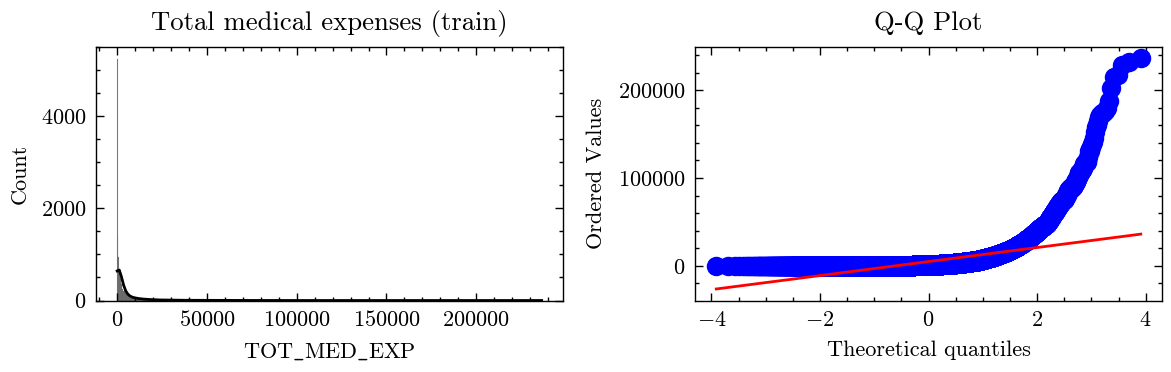

Original data summary:
	Minimum: 0.0000
	Maximum: 236449.0000
	Mean: 4931.6669
	Standard Deviation: 12802.5923
	Number of Zeros: 2980
Transformed data summary:
	Minimum: 0.0000
	Maximum: 236449.0000
	Mean: 4931.6669
	Standard Deviation: 12802.5923
	Number of Zeros: 2980


In [11]:
st.plot_distribution_fits(
    df_train_mirror,
    REG_TARGET,
    distribution=None,
    style=PAPER_STYLE,
    stat="count",
    titles=["Total medical expenses (train)"],
)

In [12]:
print(
    helpers.describe_cols(
        df_train_mirror,
        dummy_is_categorical=False,
        consecutive_sequences_are_categorical=False,
        low_unique_int_values_are_categorical=False,
    )
)

+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------------------+
| Column Name (Total=109) |     Type    |    Mean   | Standard Deviation |  Min   |    25%    |    50%    |    75%    |    Max     |                       Value Counts                       |
+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------------------+
|           RACE          | Categorical |           |                    |        |           |           |           |            | {'Non-White': '8754 (58.36%)', 'White': '6246 (41.64%)'} |
|        ACTIV_LIM        |  Numerical  |   1.862   |       0.625        | -8.000 |   2.000   |   2.000   |   2.000   |   2.000    |                                                          |
|        ADHD_DIAG        |  Numerical  

In [13]:
categorical_cols, numerical_cols = helpers.categorical_and_numerical_columns(
    df_train_mirror.drop(columns=[REG_TARGET]),
    consecutive_sequences_are_categorical=False,
    low_unique_int_values_are_categorical=False,
)

# One-Hot encoding for categorical columns (with non-numeric values only)
categorical_encoder, df_train_mirror = helpers.handle_categorical_cols(
    df_train_mirror, categorical_cols, return_only_encoded=False
)
df_train_mirror = df_train_mirror.copy()

print(f"Numerical ({len(numerical_cols)}) ", numerical_cols)
print(f"Categorical ({len(categorical_cols)}): ", categorical_cols)
print(f"Number of columns after one-hot encoding: {df_train_mirror.shape[1]}")

Numerical (107)  ['NO_WORK_WHY', 'TAX_FORM_TYP', 'WEAR_SEATBLT', 'INSUR_COV', 'PREGNT', 'PENSN_PLAN', 'MENTAL_HLTH_SCR', 'DOC_TIM_ALN', 'ARTHR_TYPE', 'SMOK', 'ADHD_DIAG', 'CHILD_SUPP', 'PANEL', 'FAM_INCOME', 'DISPSN_STAT', 'DAYS_CAREOTHR_NOWORK', 'COGNTV_LIM', 'ARTHR_DIAG', 'FOOD_STMP_VAL', 'JNT_PAIN', 'BM_IDX', 'AGE_DIAG_ADHD', 'ADV_EXERCISE_MORE', 'DIFFIC_HEAR', 'ADV_LAP_BLT', 'WALK_LIM', 'NUM_PRESCR_MEDS', 'POVRTY_LEV', 'PHY_HLTH_SCR', 'EMPLYMT', 'SEX', 'EMPHYM_DIAG', 'HEALTH_STAT', 'OVR_FEEL_14', 'STROKE_DIAG', 'PROB_WBHV', 'RSN_NO_MED_CKP', 'DOC_CK_BP', 'WHEN_ADV_BOOST_SEAT', 'ADV_DNTL_CKP', 'SPOUSE_PRSNT', 'COR_HRT_DIAG', 'MULT_HIGHBP', 'ACTIV_LIM', 'PROB_BILL_PAY', 'ADV_NO_FAT_FOOD', 'DELAY_PRESCR_MED', 'DIAB_MED', 'SCHOOL_LIM', 'HRT_ATT_DIAG', 'MENTAL_HLTH', 'CHRON_BRONCH', 'HOUSEWRK_LIM', 'ASTHM_DIAG', 'ASPRN_REG', 'STUDENT_STAT', 'SOCIAL_LIM', 'WHEN_ADV_LAP_BLT', 'FOOD_STMP_MNTHS', 'WHEN_ADV_EXERCISE', 'DIAB_DIAG', 'HEAR_AID', 'DAYS_ILL_NOSCHL', 'BLIND', 'EDU_YRS', 'HIGH_BP_D

In [14]:
# Only RACE_White is the new column
# If 1.0, the person is white, otherwise not
df_train_mirror.rename(columns={"RACE_White": "RACE"}, inplace=True)

print(
    helpers.describe_cols(
        df_train_mirror,
        dummy_is_categorical=True,
        consecutive_sequences_are_categorical=False,
        low_unique_int_values_are_categorical=False,
    )
)

+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------+
| Column Name (Total=109) |     Type    |    Mean   | Standard Deviation |  Min   |    25%    |    50%    |    75%    |    Max     |                 Value Counts                 |
+-------------------------+-------------+-----------+--------------------+--------+-----------+-----------+-----------+------------+----------------------------------------------+
|           RACE          | Categorical |           |                    |        |           |           |           |            | {0.0: '8754 (58.36%)', 1.0: '6246 (41.64%)'} |
|        ACTIV_LIM        |  Numerical  |   1.862   |       0.625        | -8.000 |   2.000   |   2.000   |   2.000   |   2.000    |                                              |
|        ADHD_DIAG        |  Numerical  |   -0.922  |       0.483        | -9.000 |   -1.000  |   -1

### *Variance Threshold Analysis*

In [15]:
VARIANCE_THRESHOLD = 0.01  # Drop (quasi-constant) columns with variance < 0.01

# Don't include the target variable in the variance thresholding obviously
df_train_without_reg_target = df_train_mirror.drop(columns=[REG_TARGET])

var_thresh = VarianceThreshold(threshold=VARIANCE_THRESHOLD)
var_thresh.fit(df_train_without_reg_target)
low_variance_cols = df_train_without_reg_target.columns[~var_thresh.get_support()].tolist()
print(f"Columns with var < {VARIANCE_THRESHOLD} ({len(low_variance_cols)}): ", low_variance_cols)

df_train_mirror.drop(columns=low_variance_cols, inplace=True)
print(f"Number of columns after dropping low variance columns: {df_train_mirror.shape[1]}")

# Remove the low variance columns from the categorical and numerical columns
numerical_cols = helpers.filter_values(numerical_cols, low_variance_cols)
categorical_cols = helpers.filter_values(categorical_cols, low_variance_cols)

Columns with var < 0.01 (2):  ['ADV_BOOST_SEAT', 'WHEN_ADV_BOOST_SEAT']
Number of columns after dropping low variance columns: 107


### *Skewness Analysis*

In [16]:
# Find Skewed Features in columns that are most definitely numerical
_, definitely_numerical_cols = helpers.categorical_and_numerical_columns(
    df_train_mirror.drop(columns=[REG_TARGET]),
    dummy_is_categorical=True,
    consecutive_sequences_are_categorical=True,
    low_unique_int_values_are_categorical=True,
)

skewed_feats = (
    df_train[definitely_numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
)
print("\nSkew in numerical columns: \n")
skewed_numerical_cols = pd.DataFrame({"Skew": skewed_feats})
print(skewed_numerical_cols.head(10))

skewed_numerical_cols = skewed_numerical_cols[abs(skewed_numerical_cols) > 0.75]
print("\nThere are {} skewed numerical columns".format(skewed_numerical_cols.shape[0]))

skewed_numerical_cols = skewed_numerical_cols.index.tolist()

2024-08-18 22:28:06,835 - root - WARNING - Likely categorical columns detected: ['SEX', 'PANEL', 'STUDENT_STAT', 'MIL_ACTIV_DUTY', 'HON_DISCHARGE', 'HEALTH_STAT', 'MENTAL_HLTH', 'CHRON_BRONCH', 'JNT_PAIN', 'PREGNT', 'WALK_LIM', 'ACTIV_LIM', 'SOCIAL_LIM', 'COGNTV_LIM', 'EMPLYMT', 'REGION', 'MARITAL_STAT', 'POVRTY_CAT', 'INSUR_COV', 'MULT_HIGHBP', 'HOUSEWRK_LIM', 'SCHOOL_LIM', 'ADV_NO_FAT_FOOD', 'ADV_EXERCISE_MORE', 'ADV_DNTL_CKP', 'FREQ_DNTL_CKP', 'RSN_NO_DNTL_CKP', 'RSN_NO_MED_CKP', 'EMPLYR_INS', 'DOC_CK_BP', 'TAKE_RISK', 'NUM_DEP_OUT_REP_UNT', 'FEEL_DEPRS', 'ADV_NO_SMKG', 'AGE_DIAG_ADHD', 'PROB_WKIDS', 'PROB_WBHV', 'WEAR_SEATBLT', 'EDU_DEG', 'SPOUSE_PRSNT', 'TAX_FORM_TYP', 'WHEN_ADV_LAP_BLT', 'WHEN_LST_ASTHMA', 'DELAY_PRESCR_MED', 'ADV_LAP_BLT', 'ADV_EAT_HLTHY', 'DOC_TIM_ALN', 'APPT_REG_MEDCARE', 'LOST_ALL_TEETH', 'PROB_BILL_PAY', 'ASPRN_REG', 'OCCUP', 'DIFF_ERRND_ALN', 'DIAB_KIDNY', 'DIAB_INSLN', 'DIAB_MED', 'DISPSN_STAT', 'TIME_LAST_PSA', 'WHEN_ADV_EXERCISE', 'UNION_STAT', 'DEAF', '

In [17]:
# Apply a Yeo-Johnson transformation to skewed features
df_train_mirror[skewed_numerical_cols] = PowerTransformer(method="yeo-johnson").fit_transform(
    df_train_mirror[skewed_numerical_cols]
)

### *Correlation Analysis*


Found 6 cols with correlation >= 0.9
['SCHOOL_LIM', 'PROB_WBHV', 'ADV_EAT_HLTHY', 'POVRTY_LEV', 'UNION_STAT', 'UNABL_PRES_MED']


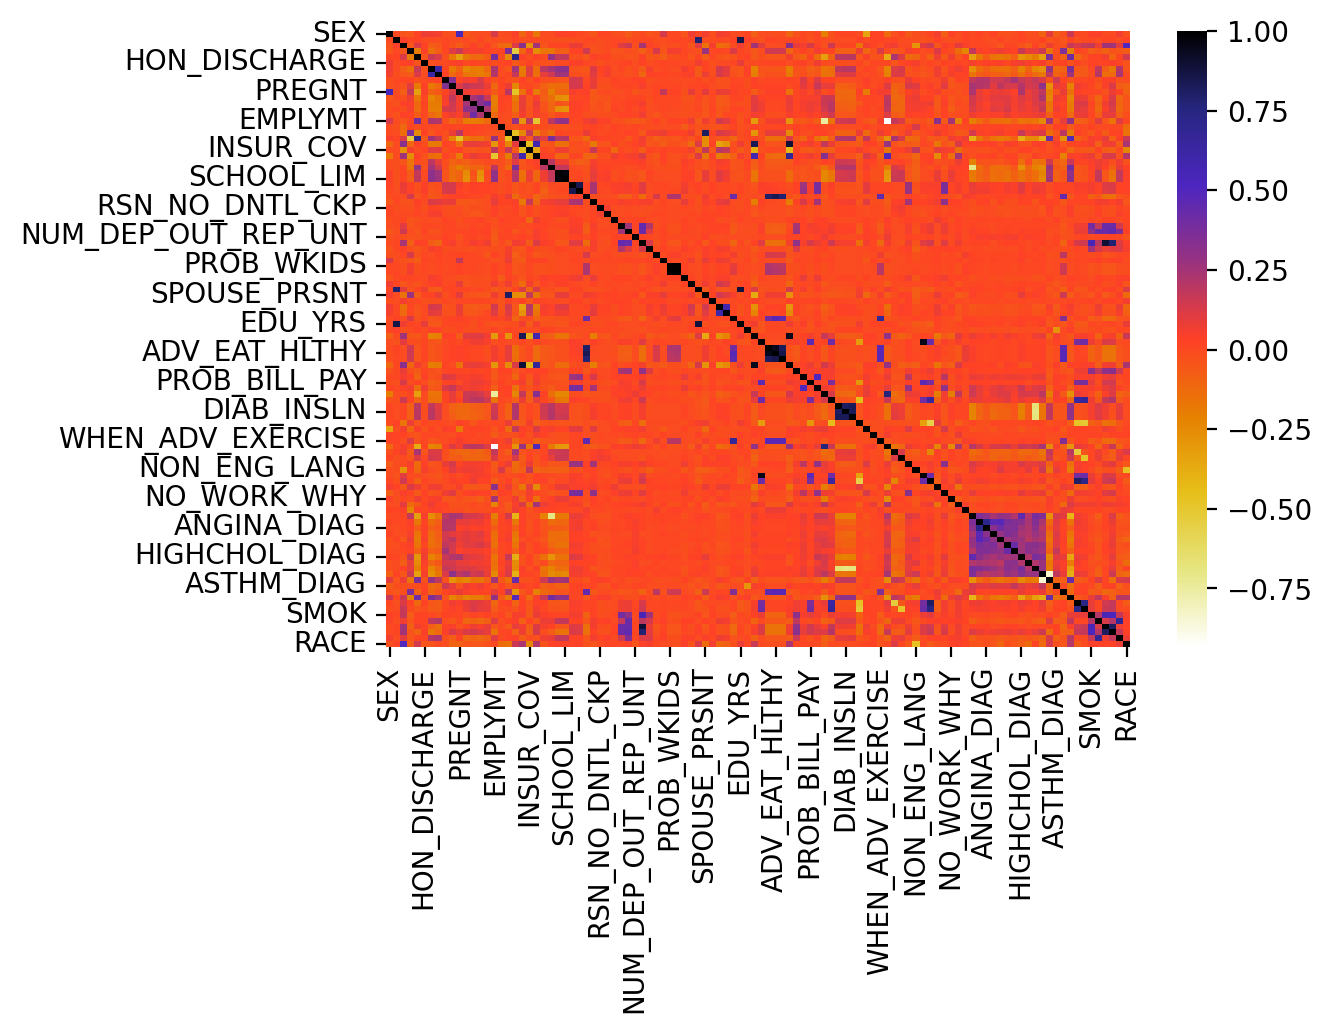

+----------------------------------------------------------------------+
|                         Correlation Summary                          |
+-------------------+------------------+---------------------+---------+
| Correlated Column | Correlated With  |     Correlation     | p-value |
+-------------------+------------------+---------------------+---------+
|     UNION_STAT    |     EMPLYMT      | -0.9335300079044023 |   0.0   |
|     SCHOOL_LIM    |   HOUSEWRK_LIM   |  0.9769131590922299 |   0.0   |
|     PROB_WBHV     |    PROB_WKIDS    |  0.9971318581558912 |   0.0   |
|     POVRTY_LEV    |    FAM_INCOME    |  0.9416967980099031 |   0.0   |
|   UNABL_PRES_MED  | DELAY_PRESCR_MED |  0.9492157211126457 |   0.0   |
|   ADV_EAT_HLTHY   |   ADV_LAP_BLT    |  0.9432248025238906 |   0.0   |
+-------------------+------------------+---------------------+---------+
Number of columns after dropping correlated columns: 101


In [18]:
# Get the correlation matrix of the data (excluding the regression and classification targets!)
# Find the columns that are highly correlated with each other and remove them
CORRELATION_THRESHOLD = 0.9  # 90% correlation threshold

df_train_without_reg_target = df_train_mirror.drop(columns=[REG_TARGET])
correlated_cols, corr, summary = st.correlated_columns(
    df_train_without_reg_target, threshold=CORRELATION_THRESHOLD
)

print(f"\nFound {len(correlated_cols)} cols with correlation >= {CORRELATION_THRESHOLD}")
print(correlated_cols)

plt.figure(figsize=(6, 4))
sns.heatmap(corr, cmap=plt.cm.CMRmap_r)
plt.show()

summary_table = helpers.make_pretty_table(
    summary,
    ["Correlated Column", "Correlated With", "Correlation", "p-value"],
    title="Correlation Summary",
)
print(summary_table)

df_train_mirror.drop(columns=correlated_cols, inplace=True)
print(f"Number of columns after dropping correlated columns: {df_train_mirror.shape[1]}")

2024-08-18 22:28:10,719 - root - WARNING - Likely categorical columns detected: ['SEX', 'PANEL', 'STUDENT_STAT', 'MIL_ACTIV_DUTY', 'HON_DISCHARGE', 'HEALTH_STAT', 'MENTAL_HLTH', 'CHRON_BRONCH', 'JNT_PAIN', 'PREGNT', 'WALK_LIM', 'ACTIV_LIM', 'SOCIAL_LIM', 'COGNTV_LIM', 'EMPLYMT', 'REGION', 'MARITAL_STAT', 'POVRTY_CAT', 'INSUR_COV', 'MULT_HIGHBP', 'HOUSEWRK_LIM', 'ADV_NO_FAT_FOOD', 'ADV_EXERCISE_MORE', 'ADV_DNTL_CKP', 'FREQ_DNTL_CKP', 'RSN_NO_DNTL_CKP', 'RSN_NO_MED_CKP', 'EMPLYR_INS', 'DOC_CK_BP', 'TAKE_RISK', 'NUM_DEP_OUT_REP_UNT', 'FEEL_DEPRS', 'ADV_NO_SMKG', 'AGE_DIAG_ADHD', 'PROB_WKIDS', 'WEAR_SEATBLT', 'EDU_DEG', 'SPOUSE_PRSNT', 'TAX_FORM_TYP', 'WHEN_ADV_LAP_BLT', 'WHEN_LST_ASTHMA', 'DELAY_PRESCR_MED', 'ADV_LAP_BLT', 'DOC_TIM_ALN', 'APPT_REG_MEDCARE', 'LOST_ALL_TEETH', 'PROB_BILL_PAY', 'ASPRN_REG', 'OCCUP', 'DIFF_ERRND_ALN', 'DIAB_KIDNY', 'DIAB_INSLN', 'DIAB_MED', 'DISPSN_STAT', 'TIME_LAST_PSA', 'WHEN_ADV_EXERCISE', 'DEAF', 'BLIND', 'LAST_FLU_VAC', 'NON_ENG_LANG', 'HEAR_AID', 'PENSN

/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:396: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


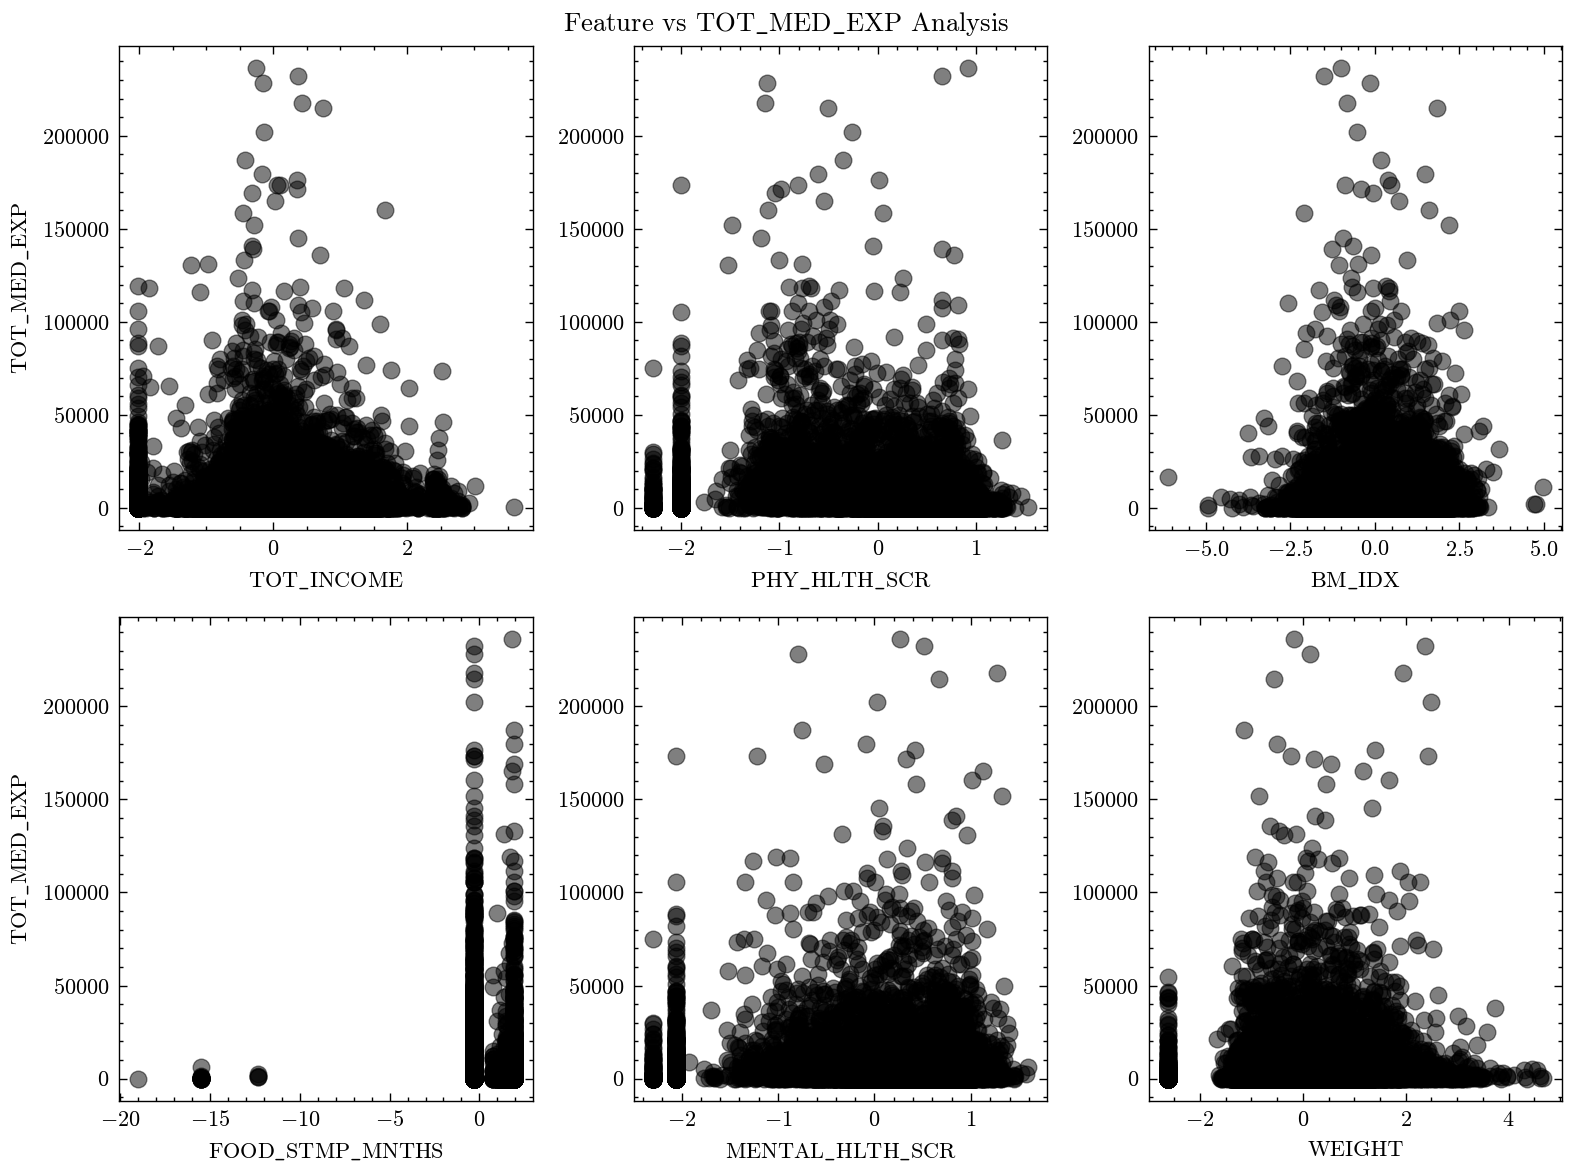

In [19]:
plots.plot_features_vs_target(
    df_train_mirror, REG_TARGET, style=PAPER_STYLE, n_features=6, max_rows=2
)

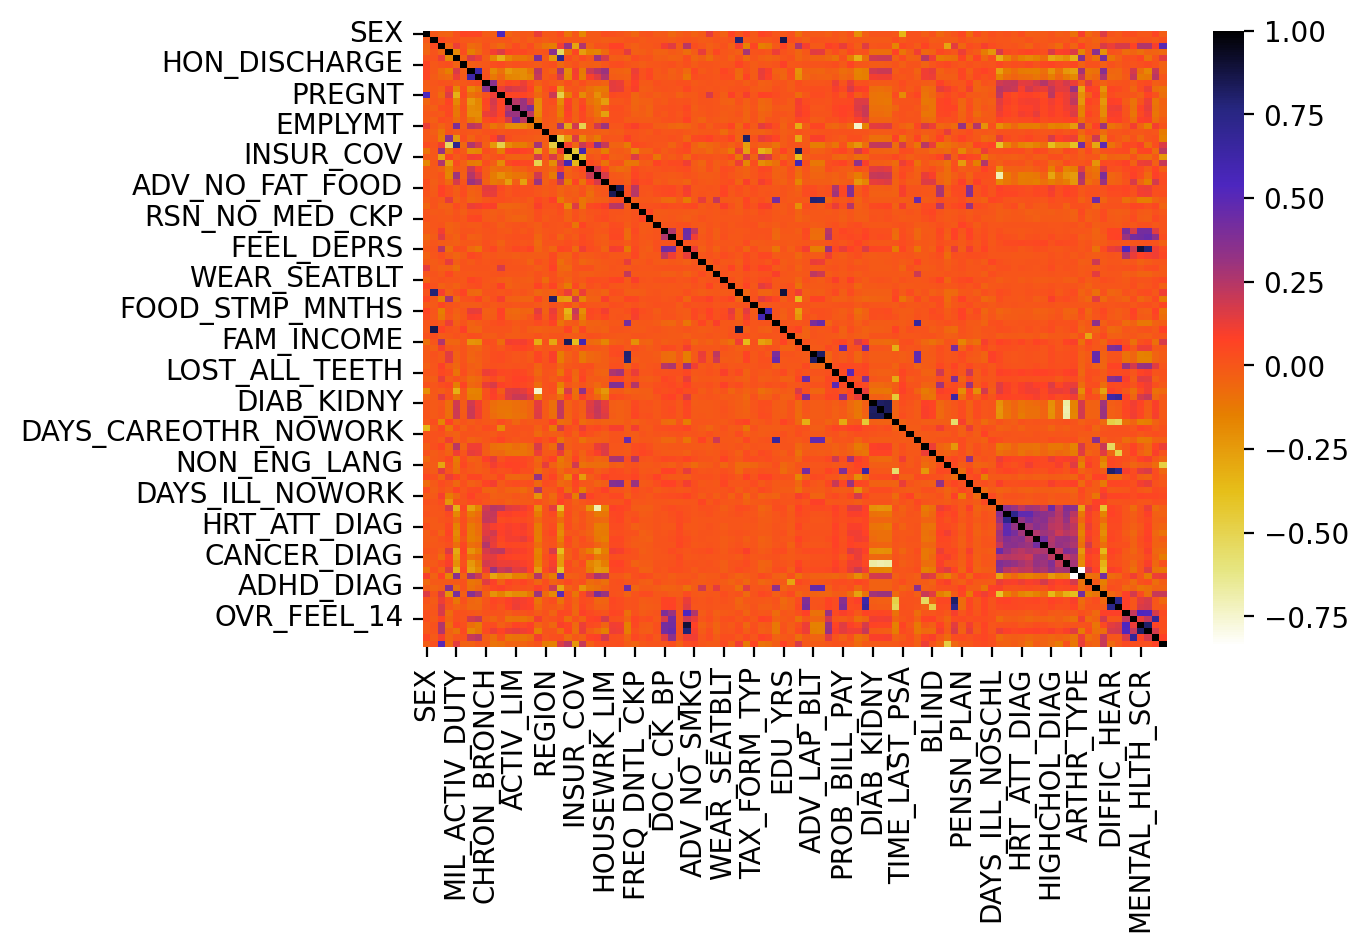

In [20]:
# After Feature Selection
df_train_without_reg_target = df_train_mirror.drop(columns=[REG_TARGET])
_, new_corr, _ = st.correlated_columns(
    df_train_without_reg_target, threshold=CORRELATION_THRESHOLD
)

plt.figure(figsize=(6, 4))
sns.heatmap(new_corr, cmap=plt.cm.CMRmap_r)
plt.show()

### *One-Hot Encoding of Likely Categorical Features*


In [21]:
categorical_cols, numerical_cols = helpers.categorical_and_numerical_columns(
    # Drop the target variable and other columns that will be dropped during training
    df_train.drop(columns=[REG_TARGET] + correlated_cols + low_variance_cols), 
    dummy_is_categorical=True,
    consecutive_sequences_are_categorical=True,
    low_unique_int_values_are_categorical=True,
)

categorical_encoder, df_train = helpers.handle_categorical_cols(
    df_train, categorical_cols, return_only_encoded=False
)

print(
    helpers.describe_cols(
        df_train,
        dummy_is_categorical=True,
        consecutive_sequences_are_categorical=True,
        low_unique_int_values_are_categorical=True,
    )
)

print(f"Number of numerical columns: {len(numerical_cols)}")
print(f"Number of categorical columns: {len(categorical_cols)}")

2024-08-18 22:28:15,144 - root - WARNING - Likely categorical columns detected: ['SEX', 'PANEL', 'STUDENT_STAT', 'MIL_ACTIV_DUTY', 'HON_DISCHARGE', 'HEALTH_STAT', 'MENTAL_HLTH', 'CHRON_BRONCH', 'JNT_PAIN', 'PREGNT', 'WALK_LIM', 'ACTIV_LIM', 'SOCIAL_LIM', 'COGNTV_LIM', 'EMPLYMT', 'REGION', 'MARITAL_STAT', 'POVRTY_CAT', 'INSUR_COV', 'MULT_HIGHBP', 'HOUSEWRK_LIM', 'ADV_NO_FAT_FOOD', 'ADV_EXERCISE_MORE', 'ADV_DNTL_CKP', 'FREQ_DNTL_CKP', 'RSN_NO_DNTL_CKP', 'RSN_NO_MED_CKP', 'EMPLYR_INS', 'DOC_CK_BP', 'TAKE_RISK', 'NUM_DEP_OUT_REP_UNT', 'FEEL_DEPRS', 'ADV_NO_SMKG', 'AGE_DIAG_ADHD', 'PROB_WKIDS', 'WEAR_SEATBLT', 'EDU_DEG', 'SPOUSE_PRSNT', 'TAX_FORM_TYP', 'WHEN_ADV_LAP_BLT', 'WHEN_LST_ASTHMA', 'DELAY_PRESCR_MED', 'ADV_LAP_BLT', 'DOC_TIM_ALN', 'APPT_REG_MEDCARE', 'LOST_ALL_TEETH', 'PROB_BILL_PAY', 'ASPRN_REG', 'OCCUP', 'DIFF_ERRND_ALN', 'DIAB_KIDNY', 'DIAB_INSLN', 'DIAB_MED', 'DISPSN_STAT', 'TIME_LAST_PSA', 'WHEN_ADV_EXERCISE', 'DEAF', 'BLIND', 'LAST_FLU_VAC', 'NON_ENG_LANG', 'HEAR_AID', 'PENSN

### *Outlier Detection*

In [22]:
# outliers = st.detect_outliers(df_train_mirror, method="modified-z-score")
# outliers = st.detect_outliers(df_train_mirror, method="iqr", iqr_lower_percentile=1, iqr_upper_percentile=99)
outliers = st.detect_outliers(df_train_mirror, method="isolation-forest")
print(f"Found {outliers.sum()} outliers of {df_train.shape[0]} samples")

# Drop the outliers
df_train = df_train[~outliers]
df_train_mirror = df_train_mirror[~outliers]
print(f"Number of samples after dropping outliers: {df_train_mirror.shape[0]}")

Found 637 outliers of 15000 samples
Number of samples after dropping outliers: 14363


In [23]:
# Split into features and target for regression and classification
X = df_train.drop(columns=[REG_TARGET])
y_regression = df_train[REG_TARGET]

# **Linear regression**

In this part, we will solve an linear regression task to predict our target `TOT_MED_EXP`, i.e. total medical expences, using the other features.


In its simplest form, predictions of a linear regression model can be summarized as

$$
\hat{y} = \mathbf{w}^T \mathbf{x} = f(\mathbf{x},\mathbf{w})
$$

which can be optimized using the cost function

$$
\mathbf{w}^{*}=\underset{\mathbf{w}}{\arg \min } \frac{1}{n} \sum_{i=1}^{n}\left(y_{i}-f\left(\mathbf{x}_{i}, \mathbf{w}\right)\right)^{2}
$$

### Setup

In [24]:
RUNS_DIR = "regression_task_runs"
CLF_IS_0_DIR = os.path.join(RUNS_DIR, "clf_is_0")
REG_DIR = os.path.join(RUNS_DIR, "reg")

helpers.ensure_directory_exists(RUNS_DIR)
helpers.ensure_directory_exists(CLF_IS_0_DIR)
helpers.ensure_directory_exists(REG_DIR)

### Process the data

In [25]:
print("The dataset now has {} rows and {} columns".format(X.shape[0], X.shape[1]))

# Split X and y for training and validation purposes
X_train_reg, X_test_reg, y_train_reg, y_test_reg = helpers.make_train_test_split(
    X, y_regression, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

The dataset now has 14363 rows and 412 columns
Training shape: (11490, 412)
Testing shape: (2873, 412)


### Train a classifier for `y = 0` and `y > 0`
Since the data is highly right-skewed, i.e, too many zeroes, we can first train a classifier to find out whether the target value is zero or not. If the target value is zero, we can directly predict the output as zero. If the target value is greater than zero, we can train a linear regression model to predict the target value.

The classifier will answer the question: "Should the output be zero?" - That is, `y = 1 (True)` for `y = 0` and `y = 0 (False)` for `y > 0`.

In [26]:
# Split into features and target
df_train_y_is_0 = df_train.copy()
df_train_y_is_0[REG_TARGET] = df_train_y_is_0[REG_TARGET].apply(lambda x: 1 if x == 0 else 0)

X_is_0_clf = df_train_y_is_0.drop(columns=[REG_TARGET])
y_is_0_clf = df_train_y_is_0[REG_TARGET]

# Split X and y for training and validation purposes
X_is_0_clf_train, X_is_0_clf_test, y_is_0_clf_train, y_is_0_clf_test = (
    helpers.make_train_test_split(
        X_is_0_clf, y_is_0_clf, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
)

Training shape: (11490, 412)
Testing shape: (2873, 412)


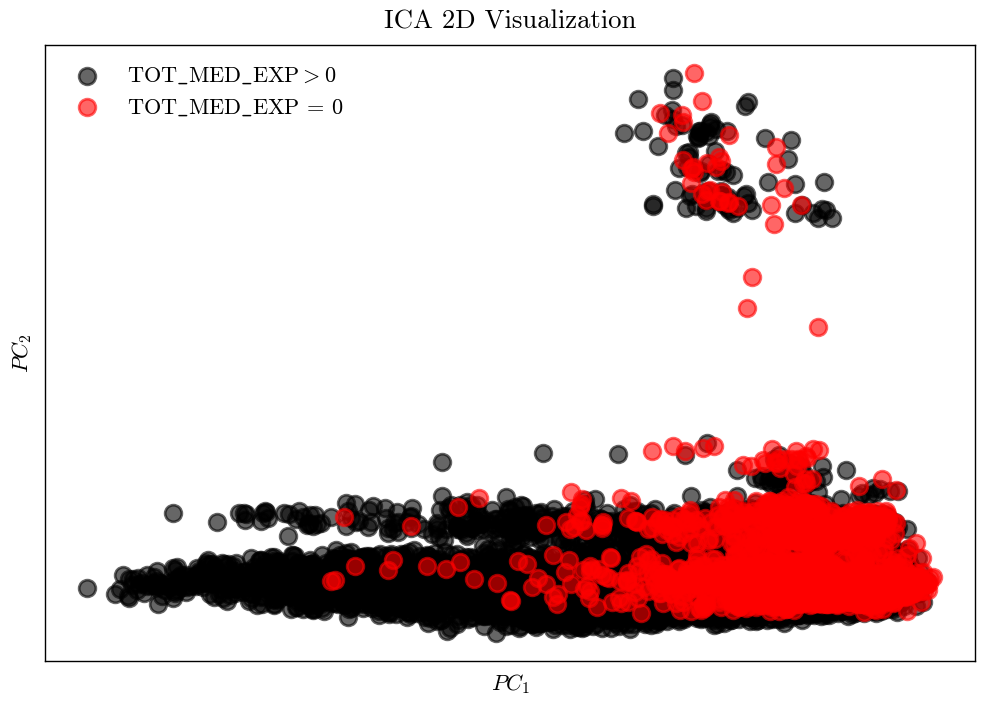

In [27]:
plots.visualize(
    X_is_0_clf,
    n_components=2,
    method="ica",
    indices=[y_is_0_clf == 0, y_is_0_clf != 0],
    labels=["TOT_MED_EXP$>$0", "TOT_MED_EXP = 0"],
    style=PAPER_STYLE
)

/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:396: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


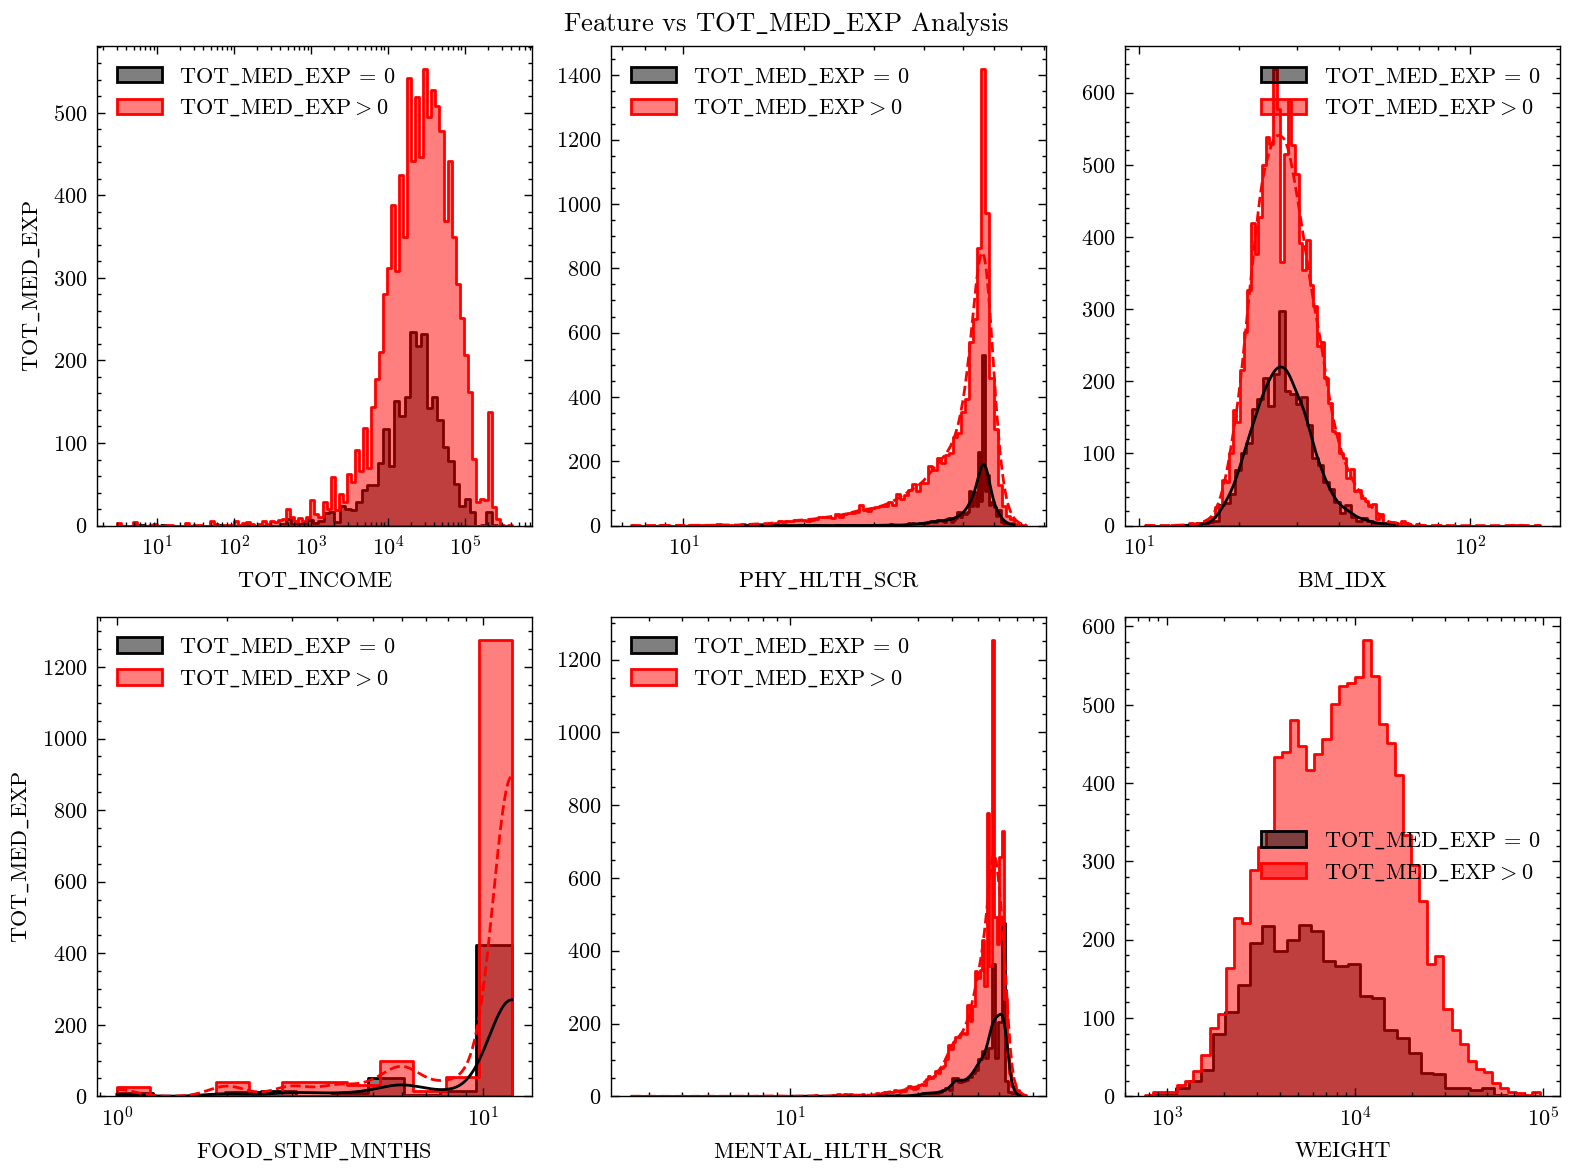

In [28]:
plots.plot_features_vs_target(
    df_train_y_is_0,
    REG_TARGET,
    features=numerical_cols,
    style=PAPER_STYLE,
    n_features=6,
    max_rows=2,
    is_categorical=True,
    categorical_legend={1: "TOT_MED_EXP = 0", 0: r"TOT_MED_EXP$>$0"},
    x_log_scale=True,
)

In [30]:
pipeline = experiments.preprocessing_pipeline(columns_to_drop=correlated_cols + low_variance_cols)

pipeline = experiments.extend_pipeline(
    pipeline,
    ("remove_constant", VarianceThreshold(threshold=0)),
    ("dimensionality_reduction", None),
    ("select", SelectKBest()),
    ("classifier", None),
)

# Define the parameter grid
base_param_grid = {
    "preprocessing__numerical__scaler": [RobustScaler()],
    "select__k": [2, 10, 80],
    "select__score_func": [f_classif, chi2, mutual_info_classif],
    # Dimensionality reduction techniques
    "dimensionality_reduction": [
        PCA(random_state=RANDOM_STATE),
        FastICA(random_state=RANDOM_STATE, whiten="unit-variance", whiten_solver="svd"),
        LinearDiscriminantAnalysis(),
        "passthrough",
    ],
    "dimensionality_reduction__n_components": [2, 10, 80, None],
    # Classifiers
    "classifier": [
        LogisticRegression(),
        MBSGDClassifier() if USE_CUML else SGDClassifier(),
        SVC(),
    ],
}

# Make a list of param grids by combining the preprocessing and classifier hyperparameters
param_grids = []
for classifier in base_param_grid["classifier"]:
    clf_param_grid = choose_param_grid(classifier, add_str_to_keys="classifier")
    combined_param_grid = combine_param_grids(base_param_grid, clf_param_grid)
    combined_param_grid = (
        [combined_param_grid] if not isinstance(combined_param_grid, list) else combined_param_grid
    )
    for grid in combined_param_grid:
        grid["classifier"] = [classifier]
        param_grids.append(grid)


# Iterate over each classifier
for param_grid in param_grids:
    current_run_dir = os.path.join(CLF_IS_0_DIR, "run_" + helpers.current_datetime())
    helpers.ensure_directory_exists(current_run_dir)

    print(f"Initializing run on {current_run_dir}:")

    # For testing purposes, make the param grid smaller (NOTE: Comment this out for the final run)
    param_grid = make_smaller_param_grid(param_grid, subset=1)

    print("\tParameter grid:")
    print(helpers.describe_param_grid(param_grid, tabs=1))

    # Run GridSearchCV
    grid_search = tuning.run_grid_search(
        X_is_0_clf_train,
        y_is_0_clf_train,
        pipeline,
        use_bayes_search=False,
        tabs=1,
        param_grid=param_grid,
        cv=5,
        refit="f1",
        scoring={
            "precision": "precision_macro",
            "recall": "recall_macro",
            "f1": "f1_macro",
        },
        n_jobs=1 if USE_CUML else -2,
        error_score=np.nan,
        return_train_score=True,
        verbose=1
    )

    print("\tBest parameters found by GridSearchCV:")
    print(helpers.pretty_print_dict(grid_search.best_params_, tabs=2))

    clf = grid_search.best_estimator_

    # Calculate metrics on train/val/test sets
    metrics = my_metrics.classification_report(
        clf,
        data={
            "train": [X_is_0_clf_train, y_is_0_clf_train],
            "test": [X_is_0_clf_test, y_is_0_clf_test],
        },
        output_dict=True,
    )
    train_val_metrics = helpers.parse_cv_results(grid_search)

    parsed_metrics = train_val_metrics
    parsed_metrics["test"] = {
        "precision": metrics["test"]["macro avg"]["precision"],
        "recall": metrics["test"]["macro avg"]["recall"],
        "f1": metrics["test"]["macro avg"]["f1-score"],
    }

    print("\tFinal Metrics:")
    print(
        helpers.tab_prettytable(
            helpers.parsed_cv_results_to_prettytable([parsed_metrics]),
            tabs=1,
        ),
    )

    # Save the results
    tuning.save_run_results(
        clf,
        pipeline,
        grid_search,
        param_grid,
        {"classification_report": metrics, "parsed": parsed_metrics},
        current_run_dir,
        name=clf.named_steps["classifier"].__class__.__name__,
    )

    print("\n" + "=" * 80 + "\n")

Initializing run on regression_task_runs/clf_is_0/run_20240818_222848:
	Parameter grid:
		preprocessing__numerical__scaler: [RobustScaler()]
		select__k: [2]
		select__score_func: [<function f_classif at 0x7fd665d122a0>]
		dimensionality_reduction: [PCA(random_state=42)]
		dimensionality_reduction__n_components: [2]
		classifier: [LogisticRegression()]
		classifier__penalty: [l2]
		classifier__C: [0.1]
		classifier__solver: [lbfgs]
		classifier__class_weight: [balanced]
		classifier__max_iter: [5000]
	Starting an initial hyperparameter search, X := (11490, 412), y := (11490,).
Fitting 5 folds for each of 1 candidates, totalling 5 fits
	Best parameters found by GridSearchCV:
		classifier: LogisticRegression(),
		classifier__C: 0.1,
		classifier__class_weight: balanced,
		classifier__max_iter: 5000,
		classifier__penalty: l2,
		classifier__solver: lbfgs,
		dimensionality_reduction: PCA(random_state=42),
		dimensionality_reduction__n_components: 2,
		preprocessing__numerical__scaler: Robu

/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

	Final Metrics:
	+-------+--------+--------+-----------+
	| Set   | recall |   f1   | precision |
	+-------+--------+--------+-----------+
	| train | 0.5000 | 0.4442 |   0.3997  |
	| val   | 0.5000 | 0.4442 |   0.3997  |
	| test  | 0.5000 | 0.4427 |   0.3971  |
	+-------+--------+--------+-----------+




/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:266: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


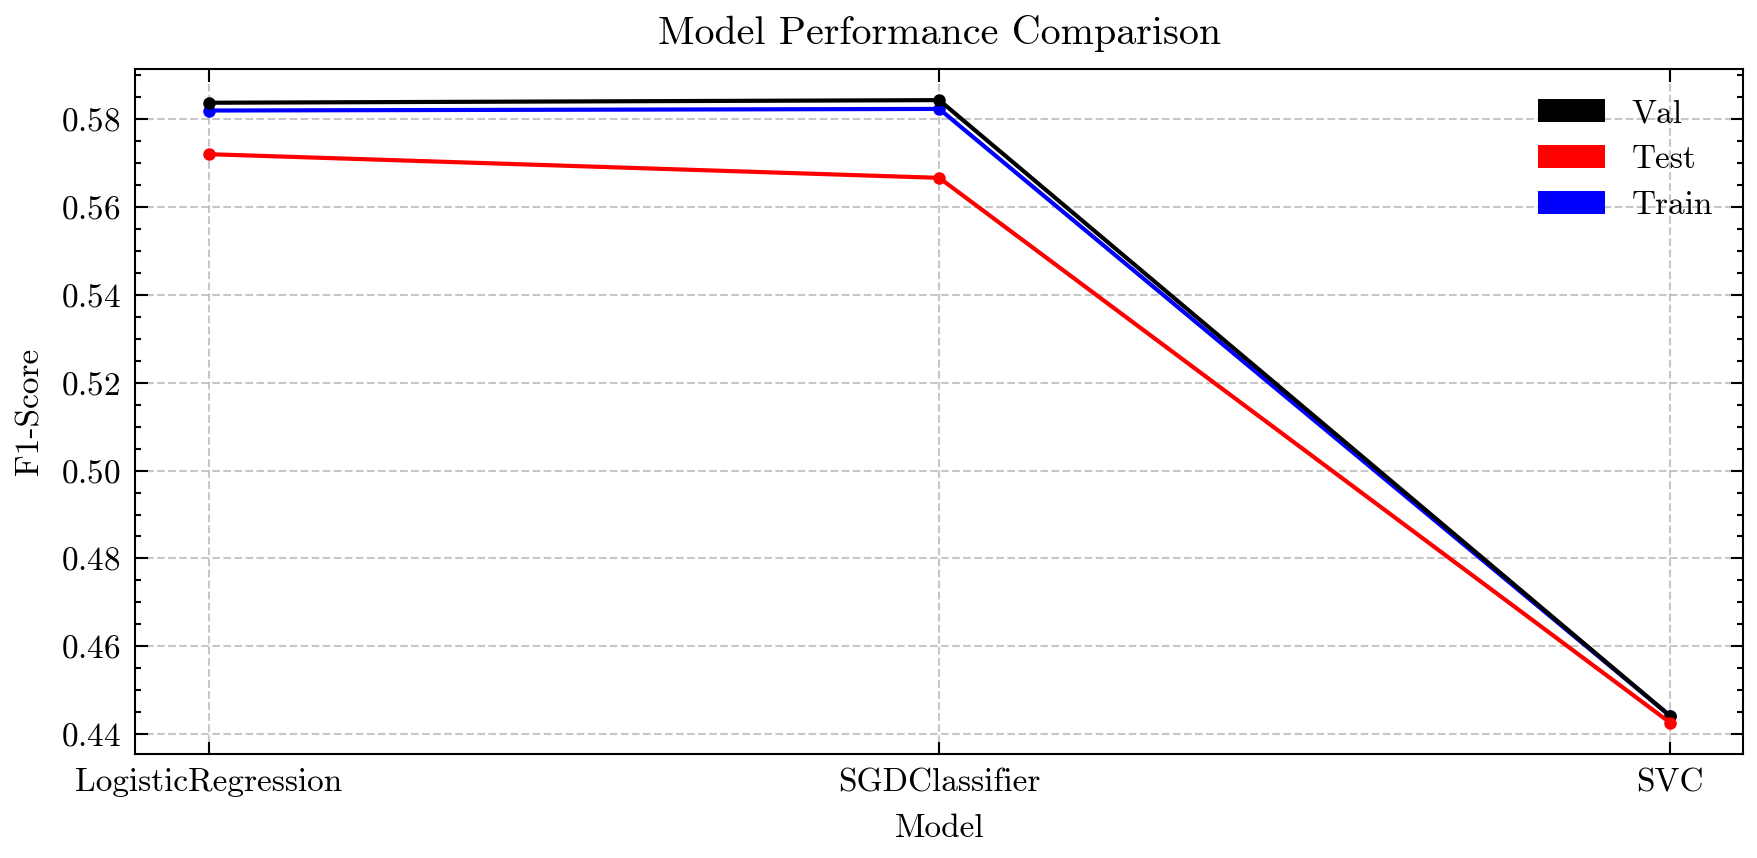

In [34]:
runs_metrics = {}
for run in os.listdir(CLF_IS_0_DIR):
    run_dir = os.path.join(CLF_IS_0_DIR, run)
    current_run_results = tuning.load_run_results(run_dir)

    if not current_run_results:
        continue

    name = current_run_results["name"]
    runs_metrics[name] = {}

    for key, value in current_run_results["metrics"]["parsed"].items():
        runs_metrics[name][key] = value

# Restructure the data
restructured_data = {"model": [], "set": [], "precision": [], "recall": [], "f1-score": []}

for model, sets in runs_metrics.items():
    for set_name, metrics in sets.items():
        restructured_data["model"].append(model)
        restructured_data["set"].append(set_name)
        restructured_data["precision"].append(metrics["precision"])
        restructured_data["recall"].append(metrics["recall"])
        restructured_data["f1-score"].append(metrics["f1"])

# Convert to DataFrame
df = pd.DataFrame(restructured_data)

# Create the GenericLinePlot instance
plotter = plots.MetricPlot()

# Set color by metric or set
plotter.set_color_by("set")  # or 'set'

# Add axes
# plotter.add_axis("precision", title="Precision")
# plotter.add_axis("recall", title="Recall")
plotter.add_axis("f1-score", title="F1-Score")

# Add data for each metric
for metric in ["f1-score"]: # ["precision", "recall", "f1-score"]:
    for set_name in ["train", "val", "test"]:
        subset = df[df["set"] == set_name]
        plotter.add_data(
            axis_name=metric,
            x=subset["model"],
            y=subset[metric],
            set_name=set_name,
            metric_name=metric,
        )

# Plot the data
plotter.plot(
    figsize=(6, 3),
    title="Model Performance Comparison",
    xlabel="Model",
    xtick_rotation=0,
    grid=True,
    style=PAPER_STYLE,
    save_path=os.path.join(CLF_IS_0_DIR, "performance_comparison.png"),
    save_format="png",
)

In [ ]:
clf

Best parameters found by grid search:
{'classifier': LogisticRegression(), 'classifier__C': 100, 'classifier__fit_intercept': True, 'classifier__penalty': 'l2', 'dimensionality_reduction': PCA(random_state=42), 'dimensionality_reduction__n_components': 100, 'preprocessing__numerical__scaler': RobustScaler(), 'select__k': 80, 'select__score_func': <function f_classif at 0x7f1dcb382200>}


/home/camilo/Repositorios/ml-healthcare-project/utils/plots.py:396: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


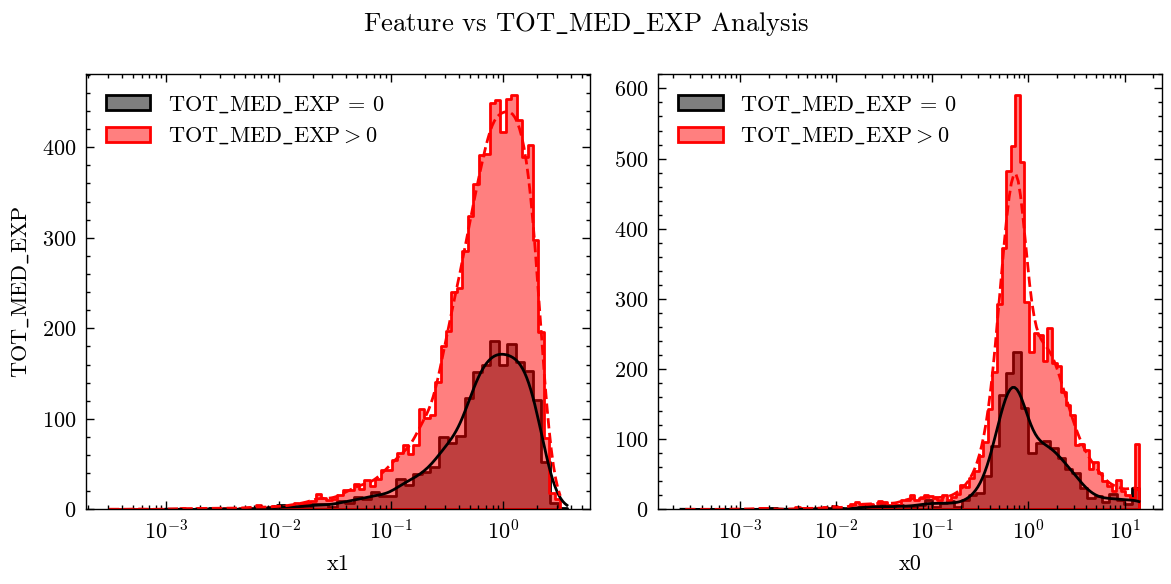

In [35]:
X_is_0_clf_transformed = clf[:-1].transform(X_is_0_clf)
X_is_0_clf_transformed[REG_TARGET] = y_is_0_clf

plots.plot_features_vs_target(
    X_is_0_clf_transformed,
    REG_TARGET,
    style=PAPER_STYLE,
    n_features=2,
    is_categorical=True,
    categorical_legend={1: "TOT_MED_EXP = 0", 0: r"TOT_MED_EXP$>$0"},
    figsize=(6, 3),
    x_log_scale=True,
)

### Train a linear regression model

In [ ]:
pipeline = experiments.preprocessing_pipeline(columns_to_drop=correlated_cols + low_variance_cols)
pipeline = experiments.extend_pipeline(
    pipeline,
    ("remove_constant", VarianceThreshold(threshold=0)),
    ("select", SelectKBest(score_func=f_regression)),
    (
        "regression",
        ZeroInflatedRegressor(regressor=LassoLars(), classifier=clf.named_steps["classifier"]),
    ),
)

param_grid = choose_param_grid(
    pipeline.named_steps["regression"].regressor, "grid", add_str_to_keys="regression__regressor"
)

# Add the number of features to select to the hyperparameter grid
param_grid["select__k"] = [10, 20, 40, 80]  # Number of top features to select for regression

param_grid["preprocessing__numerical__scaler"] = [StandardScaler(), RobustScaler()]

print(f"Using the following hyperparameter grid for {pipeline.named_steps['regression']}:")
for key, value in param_grid.items():
    print(f"\t{key}: {value}")

print()

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    refit="neg_root_mean_squared_error",
    scoring={
        "neg_root_mean_squared_error": "neg_root_mean_squared_error",
        "neg_median_absolute_error": "neg_median_absolute_error",
        "neg_mean_absolute_error": "neg_mean_absolute_error",
    },
    n_jobs=-2,
    verbose=1,
)

grid_search.fit(X_train_reg, y_train_reg)

best_estimator = grid_search.best_estimator_

print("Best hyperparameters found: ", grid_search.best_params_)

# This won't work if using PCA or Polynomial features before SelectKBest
# print(
#     "Selected features for linear regression:",
#     X.columns[grid_search.best_estimator_.named_steps["select"].get_support(indices=True)],
# )

Using the following hyperparameter grid for ZeroInflatedRegressor(classifier=LogisticRegression(C=0.1, fit_intercept=False),
                      regressor=LassoLars()):
	regression__regressor__alpha: [0.0005, 0.1, 1.0, 10.0]
	regression__regressor__fit_intercept: [True, False]
	select__k: [10, 20, 40, 80]
	preprocessing__numerical__scaler: [StandardScaler(), RobustScaler()]

Fitting 5 folds for each of 64 candidates, totalling 320 fits
2024-08-18 16:40:36,632 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:36,674 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:36,709 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:36,717 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:36,733 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:36,771 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:36,788 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=7.463e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.239e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.197e-02, with an 

2024-08-18 16:40:36,849 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:36,865 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:36,945 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,000 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=6.118e-01, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=3.788e-01, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=9.198e-01, wit

2024-08-18 16:40:37,092 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,211 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,301 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=2.490e+00, with an active set of 30 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=1.948e+00, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well 

2024-08-18 16:40:37,508 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,583 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,680 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,686 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,687 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,690 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,706 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=1.143e+00, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=5.716e-01, with an active set of 33 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.427e-01, wit

2024-08-18 16:40:37,786 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,788 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,826 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,867 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,869 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:37,937 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.100e+02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.509e+01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.980e+02, with an

2024-08-18 16:40:38,100 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.696e+02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.347e+02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well 

2024-08-18 16:40:38,316 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:38,402 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:38,479 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.994e+02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=9.123e+00, previous alpha=8.666e+00, with an active set of 18 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=1.093e+01, with an active set of 29 regres

2024-08-18 16:40:38,618 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:38,623 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:38,713 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:38,715 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:38,727 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:38,735 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:38,765 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:38,812 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=6.300e-01, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 42 iterations, i.e. alpha=2.166e-01, with an active set of 34 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 43 iterations, i.e. alpha=1.083e-01, wit

2024-08-18 16:40:38,877 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:38,878 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:39,036 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=5.120e+02, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=2.560e+02, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.261e+02, wit

2024-08-18 16:40:39,162 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:39,210 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:39,329 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:39,348 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.239e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 14 iterations, i.e. alpha=2.935e+00, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=2.881e+00, with 

2024-08-18 16:40:39,455 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:39,529 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:39,578 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:39,589 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:39,643 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:39,652 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=9.198e-01, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=4.599e-01, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=6.118e-01, wit

2024-08-18 16:40:39,662 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:39,772 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:39,841 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.484e+02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.383e+02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.070e+02, with an 

2024-08-18 16:40:39,881 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:40,042 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.980e+02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=7.587e+01, with an active set of 27 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=6.436e+01, wit

2024-08-18 16:40:40,162 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:40,204 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:40,231 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 39 iterations, alpha=4.260e+01, previous alpha=3.786e+01, with an active set of 36 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.011e+03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.529e+02, with an active set of 6 regressors

2024-08-18 16:40:40,377 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:40,386 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:40,398 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:40,452 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:40,519 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:40,529 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=6.641e+01, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 41 iterations, alpha=4.794e+01, previous alpha=4.794e+01, with an active set of 34 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=3.497e+02, with an active set of 6 regresso

2024-08-18 16:40:40,612 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:40,643 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:40,646 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:40,711 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.696e+02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.347e+02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well 

2024-08-18 16:40:40,874 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:40,899 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=1.093e+01, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 38 iterations, alpha=2.860e+00, previous alpha=2.529e+00, with an active set of 31 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=6.300e-01, with an active set of 31 regres

2024-08-18 16:40:41,205 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:41,218 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:41,293 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:41,370 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:41,379 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.142e+00, with an active set of 32 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=4.775e-01, with an active set of 33 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 41 iterations, i.e. alpha=3.482e-01, wit

2024-08-18 16:40:41,478 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:41,546 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:41,587 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:41,604 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:41,635 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=6.310e+02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=3.155e+02, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.544e+02, wit

2024-08-18 16:40:41,704 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:41,765 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:41,802 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:41,820 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=1.440e+02, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 49 iterations, i.e. alpha=3.040e+01, with an active set of 41 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well 

2024-08-18 16:40:41,958 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,045 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,228 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,253 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,257 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,282 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.484e+02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.383e+02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.070e+02, with an 

2024-08-18 16:40:42,497 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,521 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,555 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,561 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,642 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=2.490e+00, with an active set of 30 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=1.948e+00, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well 

2024-08-18 16:40:42,734 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,745 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,756 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,810 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:42,838 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.980e+02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=7.587e+01, with an active set of 27 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=6.436e+01, wit

2024-08-18 16:40:42,949 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:43,112 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.100e+02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.509e+01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.365e+02, with an

2024-08-18 16:40:43,159 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:43,199 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:43,227 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:43,350 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=4.431e+01, previous alpha=3.449e+01, with an active set of 14 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=1.994e+02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, a

2024-08-18 16:40:43,399 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:43,400 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:43,415 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:43,570 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:43,604 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=1.142e+00, with an active set of 32 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.678e+02, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=7.852e+01, wit

2024-08-18 16:40:43,642 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:43,649 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:43,771 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:43,810 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=6.310e+02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=3.155e+02, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=1.544e+02, wit

2024-08-18 16:40:43,953 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,038 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,091 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,099 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,107 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 66 iterations, alpha=6.831e+00, previous alpha=6.831e+00, with an active set of 51 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=5.240e+02, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, a

2024-08-18 16:40:44,270 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,282 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,340 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,360 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,448 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,449 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,530 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,653 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,661 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,689 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.484e+02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.383e+02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.070e+02, with an 

2024-08-18 16:40:44,761 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,889 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:44,906 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:45,072 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:45,210 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:45,211 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=1.980e+02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=7.587e+01, with an active set of 27 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 33 iterations, i.e. alpha=6.436e+01, wit

2024-08-18 16:40:45,314 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:45,340 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:45,346 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:45,359 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:45,419 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:45,442 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.100e+02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.509e+01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well cont

2024-08-18 16:40:45,526 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:45,593 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:45,599 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:45,673 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.696e+02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.347e+02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well 

2024-08-18 16:40:45,770 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:45,816 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 19 iterations, alpha=4.431e+01, previous alpha=3.449e+01, with an active set of 14 regressors.
  warnings.warn(


2024-08-18 16:40:45,972 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:46,088 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:46,169 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=1.093e+01, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=6.310e+02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 16 iterations, i.e. alpha=3.155e+02, wit

2024-08-18 16:40:46,253 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:46,325 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:46,349 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:46,351 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:46,388 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:46,388 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.678e+02, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=7.852e+01, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=7.808e+01, wit

2024-08-18 16:40:46,491 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:46,555 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:46,565 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:46,649 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:46,664 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.603e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.622e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.311e-01, with an 

2024-08-18 16:40:46,896 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:46,969 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,032 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,041 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.331e+00, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=4.746e-01, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=3.030e-01, wit

2024-08-18 16:40:47,135 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,300 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,319 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,326 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.420e+00, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=5.987e-01, with an active set of 32 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 34 iterations, i.e. alpha=3.250e-01, wit

2024-08-18 16:40:47,338 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,459 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=6.622e+01, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.665e+01, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=5.631e+01, wit

2024-08-18 16:40:47,552 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,623 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,640 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,655 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,740 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=7.079e+01, previous alpha=5.396e+01, with an active set of 33 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=2.022e+00, with an active set of 59 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 80 iterations, i.e. alpha=2.022e+00, with an active set of 60 regres

2024-08-18 16:40:47,831 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,945 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,962 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:47,970 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,016 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.635e+03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.071e+02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.387e+02, with an 

2024-08-18 16:40:48,147 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,186 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,195 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,314 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.647e+03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.252e+02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.475e+02, with an 

2024-08-18 16:40:48,451 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,463 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,504 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,531 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,562 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,636 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,638 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, alpha=1.940e+01, previous alpha=1.879e+01, with an active set of 17 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.032e+02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, a

2024-08-18 16:40:48,943 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,945 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,986 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:48,989 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:49,044 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:49,110 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:49,114 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=5.631e+02, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=2.614e+02, previous alpha=1.842e+02, with an active set of 24 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=9.762e+00, with an active set of 47 regres

2024-08-18 16:40:49,281 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:49,289 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:49,309 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:49,447 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:49,462 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:49,472 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.622e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=2.311e-01, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.239e-01, with an 

2024-08-18 16:40:49,529 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:49,557 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.420e+00, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


2024-08-18 16:40:49,775 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:49,789 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:49,809 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:49,850 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=5.885e-01, previous alpha=4.029e-01, with an active set of 37 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=8.279e+00, previous alpha=8.279e+00, with an active set of 27 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=5.987e-01, with an active set of 32 regressors, and the smallest chole

2024-08-18 16:40:50,023 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:50,068 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:50,185 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:50,222 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 55 iterations, alpha=2.573e+01, previous alpha=2.397e+01, with an active set of 46 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=6.622e+01, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.665e+01, with an active set of 20 regres

2024-08-18 16:40:50,227 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:50,311 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:50,321 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:50,346 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:50,376 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.610e+03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.059e+02, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=4.492e+02, with an 

2024-08-18 16:40:50,441 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:50,618 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:50,640 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.124e+02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=5.955e+00, previous alpha=5.633e+00, with an active set of 18 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.525e+02, with an active set of 11 regres

2024-08-18 16:40:50,646 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:50,658 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:50,844 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.032e+02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=1.685e+01, previous alpha=1.434e+01, with an active set of 16 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 22 iterations, a

2024-08-18 16:40:50,860 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:50,945 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,045 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,100 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,109 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,175 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=6.455e-01, with an active set of 31 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=9.951e-01, with an active set of 32 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 39 iterations, i.e. alpha=4.134e-01, wit

2024-08-18 16:40:51,364 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,379 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,424 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,428 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,458 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,556 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=8.659e+00, with an active set of 54 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 71 iterations, alpha=9.222e+00, previous alpha=8.659e+00, with an active set of 54 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=5.631e+02, with an active set of 15 regres

2024-08-18 16:40:51,650 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,657 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,744 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,751 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,829 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:51,841 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=9.018e+01, previous alpha=8.967e+01, with an active set of 32 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=1.331e+00, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


2024-08-18 16:40:51,927 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:52,053 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:52,107 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.491e+01, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=1.435e+01, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=6.894e+00, wit

2024-08-18 16:40:52,231 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:52,239 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:52,281 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:52,397 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:52,408 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 28 iterations, alpha=8.279e+00, previous alpha=8.279e+00, with an active set of 27 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=6.622e+01, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.665e+01, with an active set of 20 regres

2024-08-18 16:40:52,485 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:52,667 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:52,686 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=2.022e+00, with an active set of 59 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 80 iterations, i.e. alpha=2.022e+00, with an active set of 60 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 82 iterations, i.e. alpha=1.362e+00, wit

2024-08-18 16:40:52,689 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:52,692 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:52,804 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 55 iterations, alpha=2.573e+01, previous alpha=2.397e+01, with an active set of 46 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 50 iterations, i.e. alpha=1.466e+01, with an active set of 46 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=1.455e+01, with an active set of 47 regres

2024-08-18 16:40:52,925 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:52,972 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:53,027 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:53,072 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 42 iterations, alpha=7.079e+01, previous alpha=5.396e+01, with an active set of 33 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.647e+03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.252e+02, with an active set of 7 regressors

2024-08-18 16:40:53,195 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:53,267 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:53,268 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:53,292 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.525e+02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 22 iterations, i.e. alpha=6.301e+01, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well 

2024-08-18 16:40:53,423 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:53,482 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:53,514 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:53,537 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:53,576 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 35 iterations, i.e. alpha=9.481e+00, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.124e+02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well 

2024-08-18 16:40:53,740 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:53,874 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 70 iterations, i.e. alpha=8.659e+00, with an active set of 54 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 71 iterations, alpha=9.222e+00, previous alpha=8.659e+00, with an active set of 54 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, a

2024-08-18 16:40:54,021 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,050 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,097 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,147 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,201 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,209 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,294 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,332 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,339 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,397 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 57 iterations, i.e. alpha=9.762e+00, with an active set of 47 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 58 iterations, i.e. alpha=9.629e+00, with an active set of 48 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well 

2024-08-18 16:40:54,515 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,539 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,582 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,612 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=5.631e+02, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=2.614e+02, previous alpha=1.842e+02, with an active set of 24 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.491e+01, with an active set of 15 regres

2024-08-18 16:40:54,806 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,808 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:54,867 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,013 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,113 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,154 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,209 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=6.622e+01, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=5.665e+01, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 27 iterations, i.e. alpha=5.631e+01, wit

2024-08-18 16:40:55,251 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,274 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,390 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,409 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,438 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,445 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=2.065e+02, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=1.494e+01, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.635e+03, with an 

2024-08-18 16:40:55,643 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,664 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,716 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.124e+02, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=2.610e+03, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.059e+02, with a

2024-08-18 16:40:55,884 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,920 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:55,922 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:56,020 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:56,030 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:56,044 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=2.032e+02, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 21 iterations, alpha=1.685e+01, previous alpha=1.434e+01, with an active set of 16 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=2.525e+02, with an active set of 11 regres

2024-08-18 16:40:56,089 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:56,194 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:56,202 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:56,254 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:56,264 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=5.631e+02, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, alpha=2.614e+02, previous alpha=1.842e+02, with an active set of 24 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 37 iterations, a

2024-08-18 16:40:56,318 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:56,329 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:56,390 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:56,906 - root - WARNING - Regressor ignores sample_weight.
Best hyperparameters found:  {'preprocessing__numerical__scaler': RobustScaler(), 'regression__regressor__alpha': 10.0, 'regression__regressor__fit_intercept': True, 'select__k': 80}


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.593e+02, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 21 iterations, i.e. alpha=1.585e+02, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 28 iterations, i.e. alpha=1.179e+02, wit

### Train a model with a `y` transformed

See: https://scikit-learn.org/dev/auto_examples/compose/plot_transformed_target.html

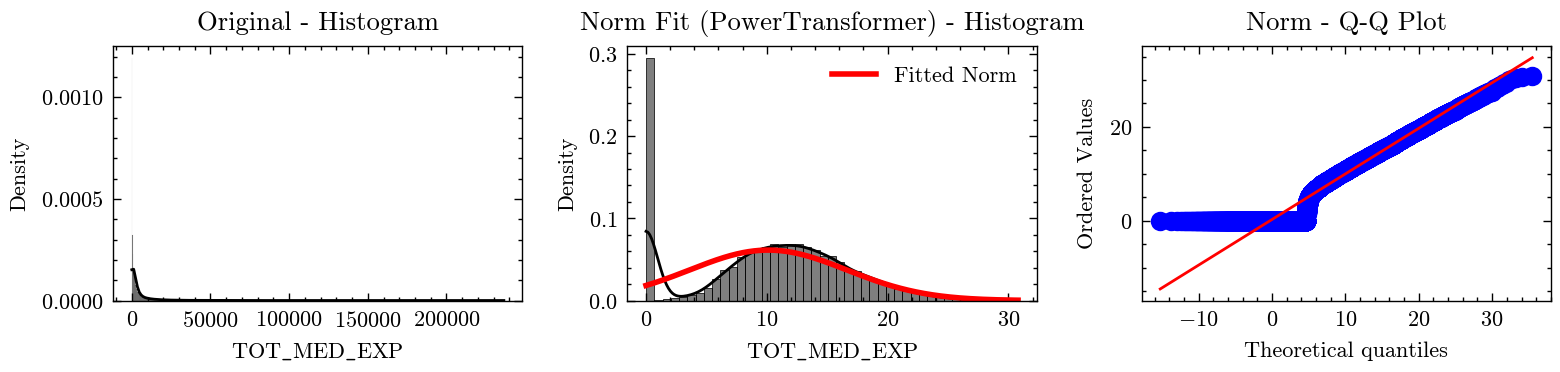

Fitted Norm distribution parameters: (10.114413308687901, 6.50271418686402)
Original data summary:
	Minimum: 0.0000
	Maximum: 236449.0000
	Mean: 4320.3351
	Standard Deviation: 11162.3014
	Number of Zeros: 2897
Transformed data summary:
	Minimum: 0.0000
	Maximum: 30.7989
	Mean: 10.1144
	Standard Deviation: 6.5027
	Number of Zeros: 2897


In [ ]:
st.plot_distribution_fits(
    df_train,
    REG_TARGET,
    apply_transform=PowerTransformer(method="yeo-johnson", standardize=False),
    show_original_histogram=True,
    style=PAPER_STYLE
)

In [ ]:
# Modify pipeline for target transformation
pipeline_y_transformed = experiments.preprocessing_pipeline(
    columns_to_drop=correlated_cols + low_variance_cols
)
pipeline_y_transformed = experiments.extend_pipeline(
    pipeline_y_transformed,
    ("remove_constant", VarianceThreshold(threshold=0)),
    ("select", SelectKBest(score_func=f_regression)),
    ("final_scale", StandardScaler()),
    (
        "regression",
        TransformedTargetRegressor(
            regressor=ZeroInflatedRegressor(
                regressor=LassoLars(), classifier=clf.named_steps["classifier"]
            ),
            transformer=PowerTransformer(method="yeo-johnson", standardize=False),
        ),
    ),
)
pipeline_y_transformed.set_output(transform="pandas")

param_grid = {}

param_grid = choose_param_grid(
    pipeline_y_transformed.named_steps["regression"].regressor.regressor,
    "grid",
    add_str_to_keys="regression__regressor__regressor",
)

# Add the number of features to select to the hyperparameter grid
param_grid["select__k"] = [10, 20, 40, 80]  # Number of top features to select for regression

param_grid["preprocessing__numerical__scaler"] = [StandardScaler(), RobustScaler()]

print(
    f"Using the following hyperparameter grid for {pipeline_y_transformed.named_steps['regression']}:"
)
for key, value in param_grid.items():
    print(f"\t{key}: {value}")

print()

grid_search = GridSearchCV(
    pipeline_y_transformed,
    param_grid=param_grid,
    cv=5,
    refit="neg_root_mean_squared_error",
    scoring={
        "neg_root_mean_squared_error": "neg_root_mean_squared_error",
        "neg_median_absolute_error": "neg_median_absolute_error",
        "neg_mean_absolute_error": "neg_mean_absolute_error",
    },
    n_jobs=-2,
    verbose=1,
)

grid_search.fit(X_train_reg, y_train_reg)

print("Best hyperparameters found: ", grid_search.best_params_)

# Get the best estimator
best_estimator_y_transformed = grid_search.best_estimator_

Using the following hyperparameter grid for TransformedTargetRegressor(regressor=ZeroInflatedRegressor(classifier=LogisticRegression(C=0.1,
                                                                                         fit_intercept=False),
                                                           regressor=LassoLars()),
                           transformer=PowerTransformer(standardize=False)):
	regression__regressor__regressor__alpha: [0.0005, 0.1, 1.0, 10.0]
	regression__regressor__regressor__fit_intercept: [True, False]
	select__k: [10, 20, 40, 80]
	preprocessing__numerical__scaler: [StandardScaler(), RobustScaler()]

Fitting 5 folds for each of 64 candidates, totalling 320 fits
2024-08-18 16:40:59,094 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:59,131 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:59,186 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:59,218 - root - WARNING - Regressor ignores sample_

/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=4.243e-01, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=6.615e-03, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=2.099e-03, with 

2024-08-18 16:40:59,454 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:59,467 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:59,468 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:59,477 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:59,477 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:59,512 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:59,539 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:59,564 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:40:59,642 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.388e-01, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.333e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well cont

2024-08-18 16:41:00,096 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:41:00,098 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:41:00,222 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:41:00,252 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:41:00,270 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:41:00,274 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.423e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=7.116e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 51 iterations, i.e. alpha=5.951e-03, with a

2024-08-18 16:41:00,317 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:41:00,330 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:41:00,413 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:41:00,497 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.399e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 11 iterations, i.e. alpha=4.008e-01, with an active set of 11 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=3.349e-01, wit

2024-08-18 16:41:00,745 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:41:00,749 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:41:00,799 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:41:00,810 - root - WARNING - Regressor ignores sample_weight.
2024-08-18 16:41:00,912 - root - WARNING - Regressor ignores sample_weight.


/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=6.017e-03, with an active set of 28 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 41 iterations, alpha=2.833e-03, previous alpha=2.393e-03, with an active set of 34 regressors.
  warnings.warn(
/home/camilo/Repositorios/venvs/gpu/lib/python3.11/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 31 iterations, a

KeyboardInterrupt: 

### Evaluate the linear regression model

/tmp/ipykernel_13534/846664241.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


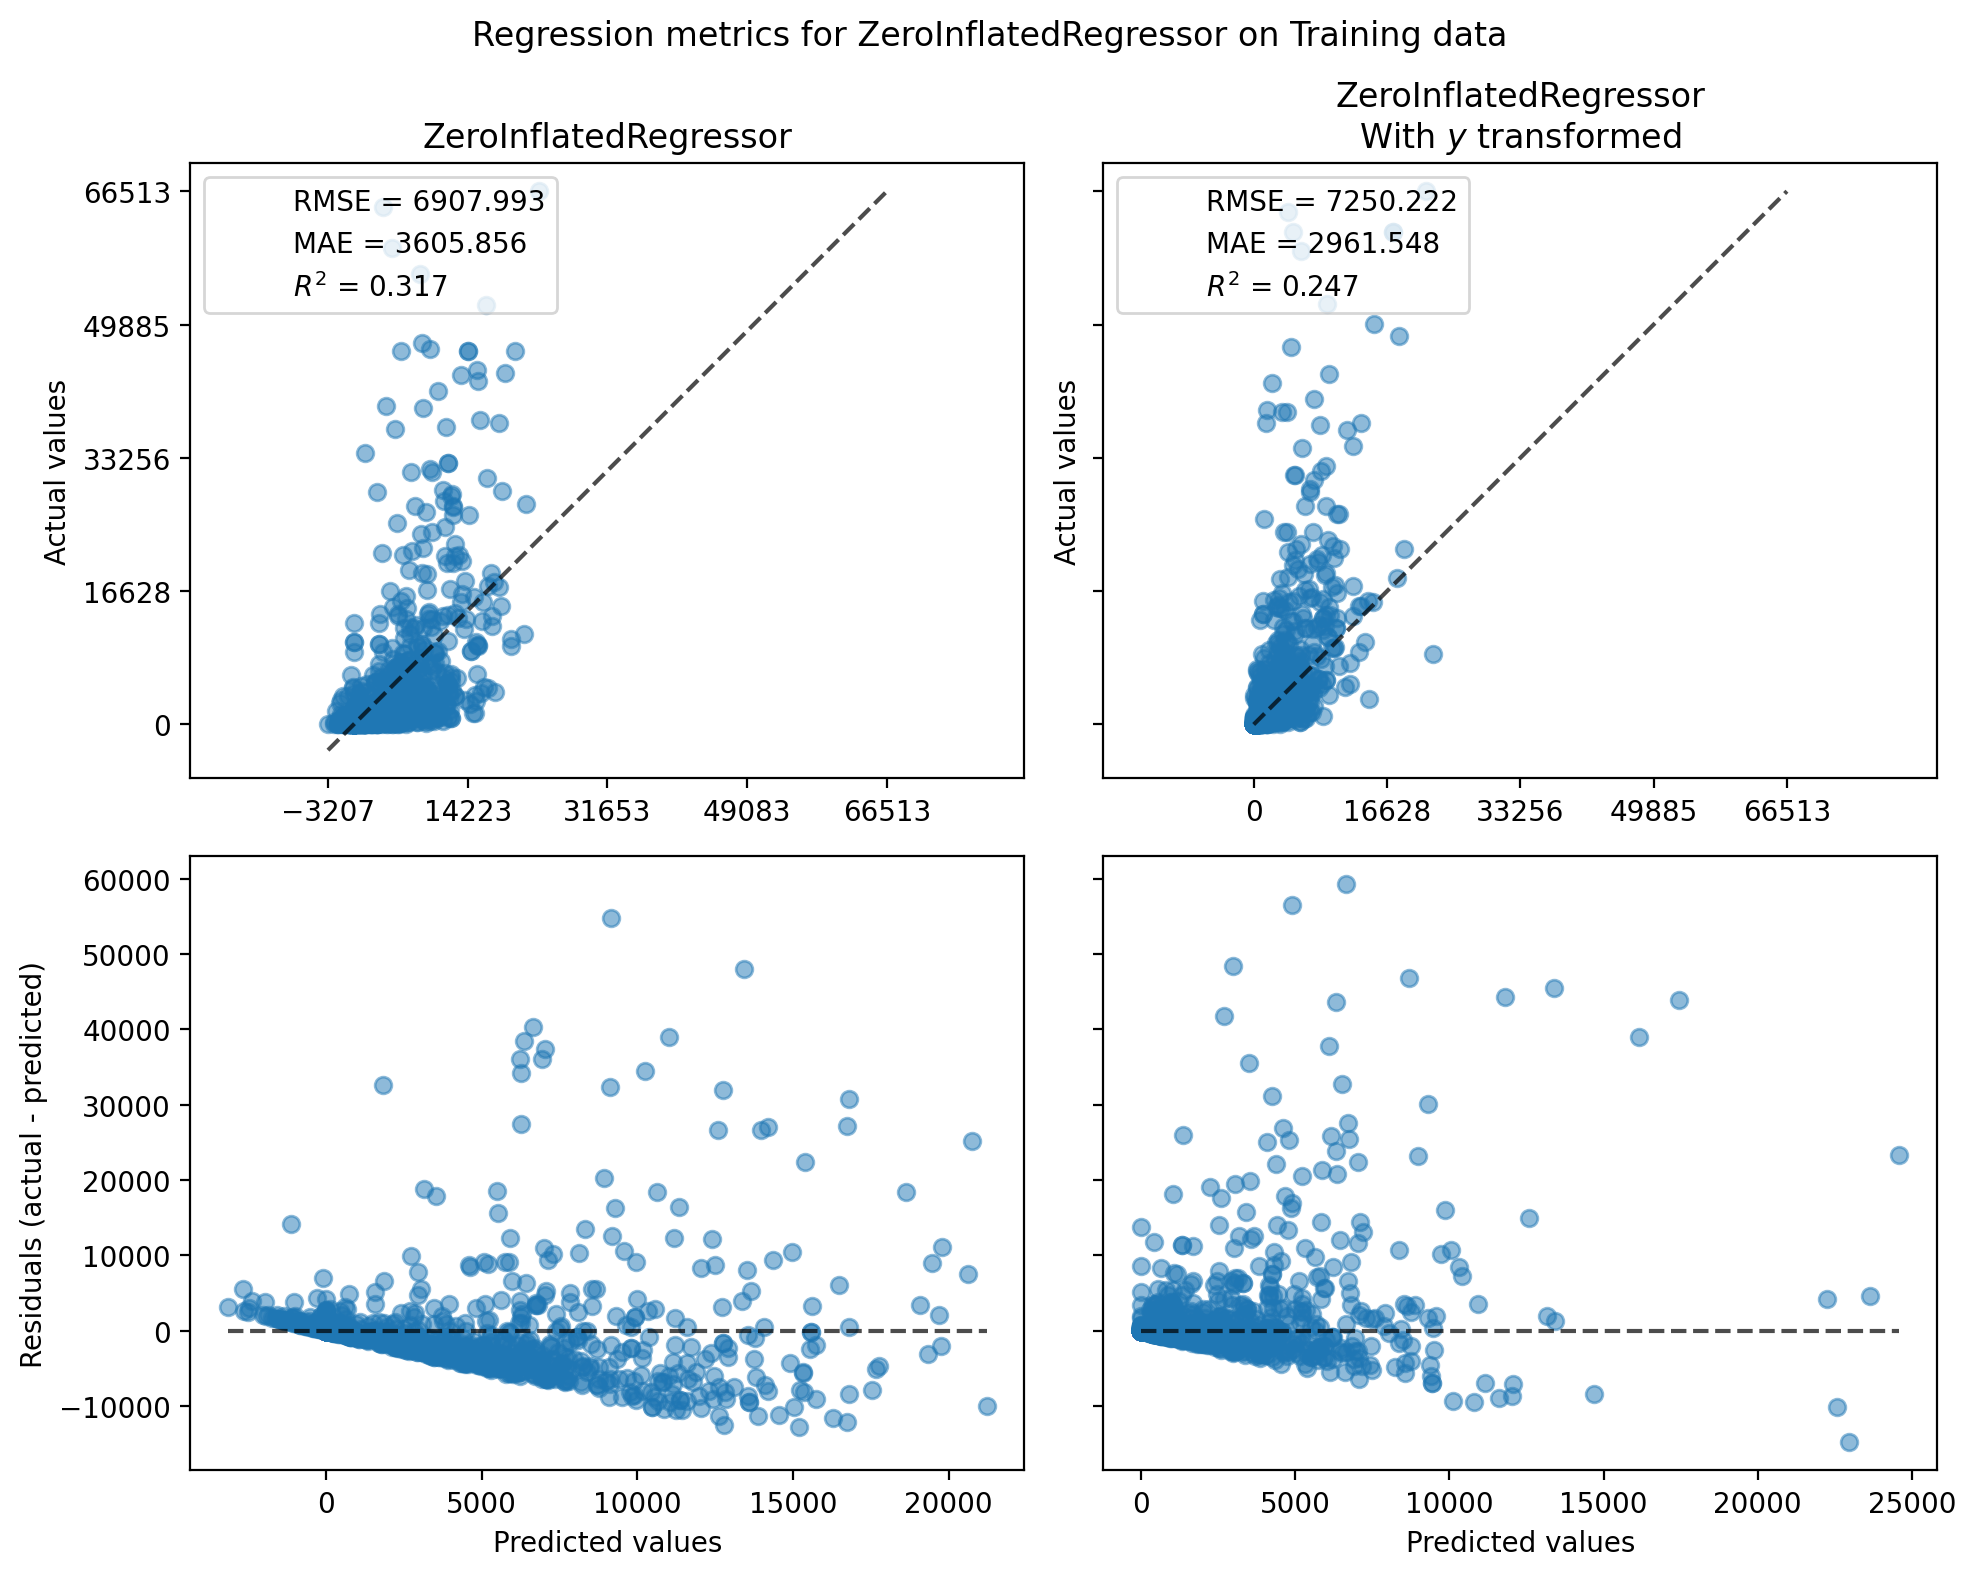




Classification performance on Training data (question: Should TOT_MED_EXP = 0? Yes: 1, No: 0):
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      1903
           1       0.93      0.93      0.93      8066

    accuracy                           0.88      9969
   macro avg       0.81      0.81      0.81      9969
weighted avg       0.88      0.88      0.88      9969

Classification performance (question: Should TOT_MED_EXP = 0? Yes: 1, No: 0) (y-transformed):
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1903
           1       0.93      0.93      0.93      8066

    accuracy                           0.88      9969
   macro avg       0.81      0.81      0.81      9969
weighted avg       0.88      0.88      0.88      9969



/tmp/ipykernel_13534/846664241.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


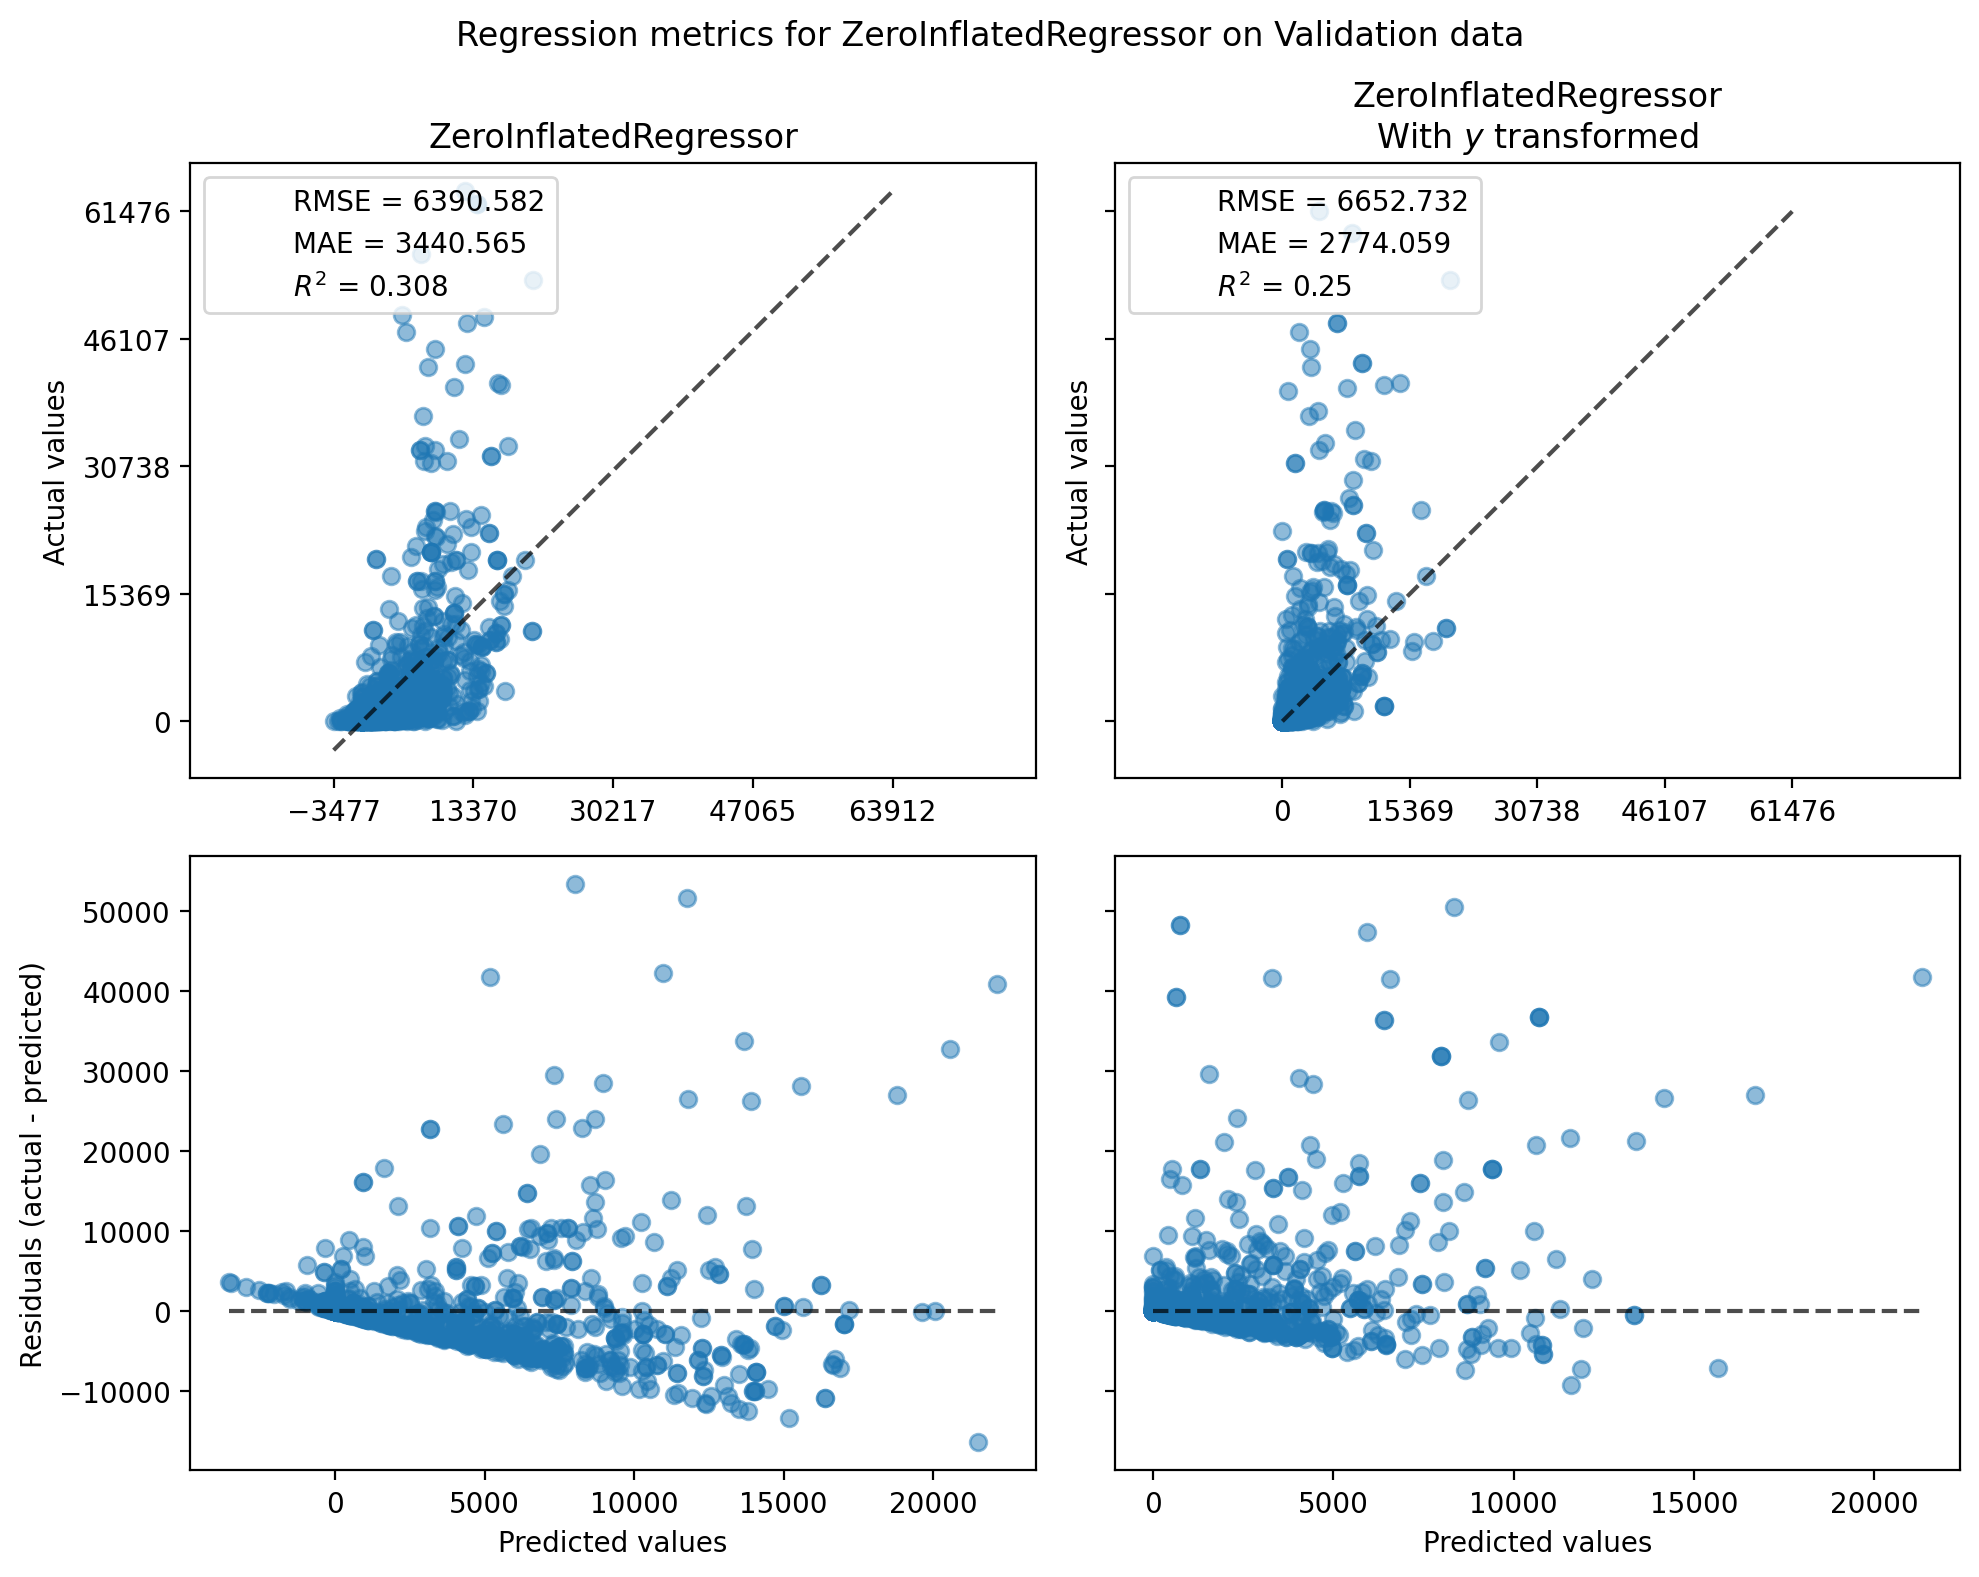




Classification performance on Validation data (question: Should TOT_MED_EXP = 0? Yes: 1, No: 0):
              precision    recall  f1-score   support

           0       0.71      0.68      0.70       497
           1       0.92      0.93      0.93      1996

    accuracy                           0.88      2493
   macro avg       0.82      0.81      0.81      2493
weighted avg       0.88      0.88      0.88      2493

Classification performance (question: Should TOT_MED_EXP = 0? Yes: 1, No: 0) (y-transformed):
              precision    recall  f1-score   support

           0       0.72      0.69      0.71       497
           1       0.92      0.93      0.93      1996

    accuracy                           0.88      2493
   macro avg       0.82      0.81      0.82      2493
weighted avg       0.88      0.88      0.88      2493

+----------------------------------------------------------------------+
|                          Regression metrics                          |
+-----

In [ ]:
regressor_name = best_estimator.named_steps["regression"].__class__.__name__

datasets = {
    "Training data": [X_train_reg, y_train_reg],
    "Validation data": [X_test_reg, y_test_reg],
}

rows = []  # For a PrettyTable
for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = best_estimator.predict(X_i)
    y_pred_transformed = best_estimator_y_transformed.predict(X_i)

    # If y == 0, then the model must predict 0, otherwise something different than 0
    y_i_clf = (y_i != 0).astype(int)
    y_pred_clf = (y_pred != 0).astype(int)
    y_pred_transformed_clf = (y_pred_transformed != 0).astype(int)

    # Compute the regression metrics
    rmse, mae, medse, medae, r2 = my_metrics.compute_scores(y_i, y_pred)
    rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed = (
        my_metrics.compute_scores(y_i, y_pred_transformed)
    )

    # Round them to 3 decimal places
    rmse, mae, medse, medae, r2 = helpers.round_values(rmse, mae, medse, medae, r2)
    rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed = (
        helpers.round_values(
            rmse_transformed, mae_transformed, medse_transformed, medae_transformed, r2_transformed
        )
    )

    metrics = [
        {
            "RMSE": rmse,
            "MAE": mae,
            "MedSE": medse,
            "MedAE": medae,
            "$R^2$": r2,
        },
        {
            "RMSE": rmse_transformed,
            "MAE": mae_transformed,
            "MedSE": medse_transformed,
            "MedAE": medae_transformed,
            "$R^2$": r2_transformed,
        },
    ]

    plots.regression_performance_comparison(
        y_i,
        y_pred,
        y_pred_transformed,
        metrics,
        suptitle=f"Regression metrics for {regressor_name} on {split_name.capitalize()}",
        regressor_name=regressor_name,
        style=PAPER_STYLE,
    )

    plt.suptitle()

    rows.append([split_name, rmse, mae, medse, medae, r2])
    rows.append(
        [
            " (y-transformed)",
            rmse_transformed,
            mae_transformed,
            medse_transformed,
            medae_transformed,
            r2_transformed,
        ]
    )

    print(
        f"Classification performance on {split_name} (question: Should {REG_TARGET} = 0? Yes: 1, No: 0):"
    )
    print(skm.classification_report(y_i_clf, y_pred_clf, zero_division=0))

    print(
        f"Classification performance (question: Should {REG_TARGET} = 0? Yes: 1, No: 0) (y-transformed):"
    )
    print(skm.classification_report(y_i_clf, y_pred_transformed_clf))

print(
    helpers.make_pretty_table(
        rows,
        title="Regression metrics",
        field_names=["Split", "RMSE", "MAE", "MedSE", "MedAE", "R^2"],
        alignments=["l"],
    )
)

### Export test set predictions for regression task

At this point, we can use our model to predict the medical expenses from the test sets. The following cell shows an example on how to do this.

You must save your predictions (`y_hat`) to a file and name the file in the following format:

`<TEAM_ID>__<SPLIT>__reg_pred.npy`

Make sure that:

`<TEAM_ID>` is your team id as given in CMS.

`<SPLIT>` is "test_public" during the semester and "test_private" for the final submission. We will write an announcement to CMS once the test_private dataset is available to download.

In [ ]:
# Run this to save a file with your predictions on the test set to be submitted
# Specify the dataset split
split = "test_public"  # Replace by 'test_private' for FINAL submission

# Load the test data
df_test = pd.read_csv(f"data/{split}.csv")

# Make sure that we keep only the categorical cols that exist here
categorical_cols = helpers.remove_non_existent_columns(categorical_cols, df_test.columns)

# Handle the categorical columns in the test set
df_test = helpers.encode_categorical_cols(
    df_test, categorical_cols, categorical_encoder, return_only_encoded=False
)

# Use the best estimator to make predictions
y_hat = best_estimator_y_transformed.predict(df_test)

# Save the results with the format <TEAM_ID>__<SPLIT>__reg_pred.npy
folder = "./results"
np.save(
    os.path.join(folder, f"{team_id}__{split}__reg_pred.npy"), y_hat
)  # Note the double underscores '__' in the filename

/home/camilo/Repositorios/venvs/venv_rapids_24.06/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [37] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Linear classification

In this part, we will train a simple linear classification model to predict our target `UTILIZATION`.


In [ ]:
k_classification = 20  # Number of top features to select for classification
select_k_best_classification = SelectKBest(score_func=chi2, k=k_classification)
X_classification_selected = select_k_best_classification.fit_transform(
    X_processed, y_classification
)
selected_features_classification = select_k_best_classification.get_support(indices=True)

NameError: name 'X_processed' is not defined

We will first change our targets (classes: LOW, HIGH) to numeric targets. Then, we solve a logistic regression problem by minimizing the binary cross-entropy function

$$
J(\theta) = -\frac{1}{n} \sum_{i=1}^{n} \left( y_i \log(p_{\theta}(\hat{y}=1 | \mathbf{x}_i)) + (1 - y_i) \log(p_{\theta}(\hat{y}=0 | \mathbf{x}_i)) \right)
$$

where $y_i \in \{0, 1\}$ and $p_{\theta}(\hat{y}=k | \mathbf{x}_i)$ is the probability assigned by our model to class $k$ having observed features $\mathbf{x}_i$.

0 refers to HIGH, and 1 refers to LOW

### Process the data

In [ ]:
df_train = pd.read_csv(f"data/train.csv")

y = df_train["UTILIZATION"]

df_train.drop(columns=["UTILIZATION", "TOT_MED_EXP"])

le = preprocessing.LabelEncoder()
df_test["RACE"] = le.fit_transform(df_test["RACE"])

y = le.fit_transform(y)  # maps HIGH to 0 and LOW to 1

print(f"Original classes {le.classes_}")
print(f"Corresponding numeric classes {le.transform(le.classes_)}")


print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}", f", unique entries in y: {np.unique(y)}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# These hyperparameters are just placeholders, choosen without much care. For a good LogisticRegression baseline, play with them a bit.
clf = linear_model.LogisticRegression(
    penalty=None,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,  # None, balanced
    random_state=None,
    solver="lbfgs",
    max_iter=1500,
    multi_class="auto",
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)

### Fit the model by using training data

In [ ]:
clf = clf.fit(X_train, y_train)

Now evaluate your model. Check the appendix for details on micro, macro and weighted averaging

In [ ]:
datasets = {"training data": [X_train, y_train], "validation data": [X_val, y_val]}

for split_name, dataset in datasets.items():
    X_i, y_i = dataset
    y_pred = clf.predict(X_i)
    print(f"\nSplit: {split_name}")

    print(skm.classification_report(y_i, y_pred))

At this point, we can use our model to predict healthcare utilization on the test set.

We again need to follow a specific namim format when saving the predictions. Similarly to before, the name of the file should be `<TEAM_ID>__<SPLIT>__clf_pred.npy`.



In [ ]:
# Run this to save a file with your predictions on the test set to be submitted

split = "test_public"  # replace by 'test_private' for FINAL submission

df_test = pd.read_csv(f"data/{split}.csv")

# Process data
df_test["RACE"] = LabelEncoder().fit_transform(df_test["RACE"])

y_hat = clf.predict(df_test)

# Save the results with the format <TEAM_ID>__<SPLIT>__clf_pred.npy

folder = "./"
np.save(os.path.join(folder, f"{team_id}__{split}__clf_pred.npy"), y_hat)

# Submission to CMS

Put your .npy files for both regression and classification tasks in the same zip file. Please name the file as `<TEAM_ID>.zip` (e.g. `123.zip`) and upload it to CMS system. It is essential that the files inside the .zip are named as follow:

`<TEAM_ID>__<SPLIT>__reg_pred.npy` \
`<TEAM_ID>__<SPLIT>__clf_pred.npy`

Above, `<SPLIT>` should correspond to `test_public` for the leaderboard and `test_private` for the final submission.
As long as the `test_private.csv` data file is not released yet, the zip will contain only two files.


### Appendix: Reminders about macro and micro averaging:

When evaluating a classification model using `skm.classification_report(y_i, y_pred)` as done above, we get a macro and a weighted average.

In the context of computing F1-score, "macro" and "micro" averaging are two commonly used techniques to aggregate the per-class F1-scores.

**Micro-average**: Compute the F1-score globally by counting the total true positives, false negatives, and false positives over all classes, and then calculating precision, recall, and F1-score using these aggregated values.

**Macro-average**: Calculate the F1-score for each class separately, and then take the average of these per-class F1-scores.

The main difference between these two techniques is the way they treat class imbalance. Micro-average treats all classes equally, regardless of their size, while macro-average treats each class equally, regardless of the number of samples in that class.

Micro-average is often used when we care about overall performance across all classes, and we want to give more weight to the performance on larger classes. In contrast, macro-average is often used when we want to evaluate the performance on each class separately and give equal weight to each class.


In addition to micro and macro averaging, there is another common technique for computing the F1-score called **weighted averaging**.

**Weighted averaging** is similar to macro averaging in that it computes the per-class F1-score and then takes the average of these scores. However, unlike macro averaging, weighted averaging takes into account the number of samples in each class when computing the average. Specifically, the weighted average is computed as follows:

- Compute the F1-score for each class separately.
- Compute the weight for each class as the number of samples in that class divided by the total number of samples.
- Compute the weighted average of the per-class F1-scores, where each per-class F1-score is weighted by the weight of that class.

The weighted average is commonly used when the dataset is imbalanced, meaning that some classes have many more samples than others. In such cases, using the simple average (macro-average) would give too much weight to the smaller classes, while using micro-average would give too much weight to the larger classes. The weighted average strikes a balance between these two approaches by giving more weight to the classes with more samples while still taking into account the performance of all classes.


When computing the F1 score for the leaderboard and the final challenge results, we will be using the macro averaging strategy.